모델 및 데이터 로드 단계
Feather 파일로 저장한 이벤트/게임/선수 데이터를 읽어온다.
- Pickle로 저장해 둔 학습된 soccermix 모델(cat_model, loc_models, dir_models)을 복원한다.
- 학습 시 계산한 이벤트별 확률 가중치(cat_weights → loc_weights → dir_weights)도 함께 로드한다.
- team_id, game_id 정보를 이벤트 행과 연결해 이후 시각화 및 분석에 활용할 수 있도록 병합한다.
- models.pkl 구조는 순서(cat_model → loc_models → dir_models)대로 로드해야 함

In [1]:
!git clone https://github.com/narame7/UOS-FootballDataAnalytics-Tutorial

Cloning into 'UOS-FootballDataAnalytics-Tutorial'...
remote: Enumerating objects: 413, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 413 (delta 6), reused 6 (delta 5), pack-reused 399 (from 2)
Receiving objects: 100% (413/413), 204.81 MiB | 20.07 MiB/s, done.
Resolving deltas: 100% (129/129), done.
Updating files: 100% (131/131), done.


In [3]:
!pip install matplotsoccer==0.0.8
!pip install matplotlib==3.7.5
!pip install cvxpy==1.5.2

  Preparing metadata (setup.py) ... done
  Created wheel for matplotsoccer: filename=matplotsoccer-0.0.8-py3-none-any.whl size=5965 sha256=e34c920c4f790a00df5cb7807b3e0f41895f4e918099b462e05e46dd70e6bd7b
  Stored in directory: /root/.cache/pip/wheels/88/6c/07/fe3601f4344f02c681a282d09ae5e317d5379d4573986b0c29
Successfully built matplotsoccer
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 108.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 105.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are i

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 14.9 MB/s eta 0:00:00
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.6.7
    Uninstalling cvxpy-1.6.7:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
^C


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!mv /content/drive/MyDrive/J1League_data/* "/content/UOS-FootballDataAnalytics-Tutorial/Week 13/data/"

In [10]:
%cd 'UOS-FootballDataAnalytics-Tutorial/Week 13'

[Errno 2] No such file or directory: 'UOS-FootballDataAnalytics-Tutorial/Week 13'
/content/UOS-FootballDataAnalytics-Tutorial/Week 13


In [11]:
import os; import sys; sys.path.insert(0, '../')
import pandas as pd
import tqdm
import pickle

import vis
import numpy as np
import warnings

In [13]:
### Configure file and folder names
data_feather = "data/soccermix_J1_all_data.feather"

models = "data/soccermix_J1_models.pkl"
c_weights = "data/soccermix_J1_all_catweights.pkl"
l_weights = "data/soccermix_J1_all_locweights.pkl"
d_weights = "data/soccermix_J1_all_dirweights.pkl"


In [14]:
def loadall(filename):
    with open(filename, "rb") as f:
        while True:
            try:
                yield pickle.load(f)
            except EOFError:
                break

items = loadall(models)
d_w = loadall(d_weights)

In [15]:
cat_model = next(items)
loc_models = next(items)
dir_models = next(items)
dir_weights = next(d_w)

In [56]:
X = pd.read_feather(data_feather)
games = pd.read_feather('data/JL_games.feather')
players = pd.read_feather('data/JL_players.feather')
teams = pd.read_feather('data/JL_teams.feather')
pg = pd.read_feather('data/JL_player_games.feather')
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

japan_id_map = dict(zip(games["home_team_name"], games["home_team_id"]))
merged_weights = dir_weights.copy()
merged_weights["team_id"] = X.team_id.values
merged_weights["game_id"] = X.game_id.values

In [18]:
compare = {1886, 1889} # 비셀 고베, 산프레체 히로시마 - 2024 J리그 1위팀, 2위팀
vectors = {}
set_teams = set(merged_weights.team_id.astype('int'))

for p in compare:
    other = compare - {p}
    p2 = next(iter(other))

    # p(team)의 홈 경기 vs p2(team)
    A_home_B = games[( (games.home_team_id == p) & (games.away_team_id == p2))].game_id.values

    # p(team)의 원정 경기 vs p2(team)
    A_away_B = games[( (games.away_team_id == p) & (games.home_team_id == p2))].game_id.values

    A_other = games[(((games.home_team_id == p) & ~(games.away_team_id == p2))
                         | ((games.away_team_id == p) & ~(games.home_team_id == p2))
                        )].game_id.values
    # 홈에서 라이벌과 경기 시 방향 확률 합
    vec1 = merged_weights.loc[((merged_weights.game_id.isin(A_home_B))
                                  & (merged_weights.team_id == p)), dir_weights.columns].sum().values
    # 라이벌 외의 팀과 경기 시 방향 확률 합
    vec2 = merged_weights.loc[((merged_weights.game_id.isin(A_other))
                                  & (merged_weights.team_id == p)), dir_weights.columns].sum().values

    vec2 /= 38
    # 원정에서 라이벌과 경기 시 방향 확률 합
    vec3 = merged_weights.loc[((merged_weights.game_id.isin(A_away_B))
                                  & (merged_weights.team_id == p)), dir_weights.columns].sum().values

    vectors[f'{int(p)}_{int(p2)}_0'] = vec1 #home game of team 1 against team 2
    vectors[f'{int(p)}_{int(p2)}_1'] = vec2 #all games of team 1 not against team 2
    vectors[f'{int(p)}_{int(p2)}_2'] = vec3 #away game of team 1 against team 2
vectors_pd = pd.concat({k: pd.DataFrame(v).T for k,v in vectors.items()}).droplevel(level=1)
vectors_pd.index.name = "team_game"
vectors_pd.columns = dir_weights.columns


### How did Vissel Kobe play differently the away game against Sanfrece (win) vs home game against Sanfrecce (draw)

In [19]:
'''
인덱스 형태	의미
A_B_0	A가 홈, B를 상대로한 경기
A_B_1	A가 B 아닌 나머지 팀 상대로한 경기
A_B_2	A가 원정, B를 상대로한 경기
'''
vectors_pd

goalkick_0_0  cross_0_0  cross_1_0  clearance_0_0  tackle_0_0  \
team_game                                                                    
1889_1886_0           6.0        5.0        7.0           19.0    5.899734   
1889_1886_1      6.368421   6.605263   6.921053      17.736842    9.792205   
1889_1886_2           8.0        3.0        4.0           41.0   16.432297   
1886_1889_0           9.0        5.0        5.0           24.0   13.935758   
1886_1889_1      6.947368   7.473684   6.947368      20.026316    8.539262   
1886_1889_2           9.0        4.0        6.0           30.0    6.024654   

             tackle_1_0   foul_0_0  corner_0_0  corner_1_0  freekick_0_0  ...  \
team_game                                                                 ...   
1889_1886_0    4.100266        9.0         4.0         4.0      9.601146  ...   
1889_1886_1      5.0499  13.631579    2.710526    3.421053     10.381604  ...   
1889_1886_2    7.567703       19.0         1.0         2.0     10.760169  ...   
1886_1889_0    7.064242       14.0         6.0         2.0     16.713275  ...   
1886_1889_1    5.539685  10.736842    2.842105    2.552632      9.621276  ...   
1886_1889_2    2.975346       14.0         2.0         2.0      6.903885  ...   

             keeper_catch_2_0  keeper_catch_3_0  keeper_catch_4_0  \
team_game                                                           
1889_1886_0          0.353654          0.001906               0.0   
1889_1886_1          0.611932          0.601055          0.003263   
1889_1886_2          0.492443          1.932158          0.013166   
1886_1889_0          0.003025          2.459013          0.000559   
1886_1889_1          0.702034          0.777715          0.002801   
1886_1889_2           1.20955          2.268348          0.005956   

             keeper_catch_4_1  interception_0_0  interception_1_0  \
team_game                                                           
1889_1886_0               0.0          3.996286          4.003713   
1889_1886_1          0.577083          5.114997          5.385003   
1889_1886_2          2.328302          5.998265          4.001735   
1886_1889_0          0.098827          6.581074          8.418926   
1886_1889_1          0.495337          5.976691           6.07594   
1886_1889_2          1.053247          9.137748          8.862252   

             take_on_0_0  throw_in_0_0  throw_in_1_0  throw_in_1_1  
team_game                                                           
1889_1886_0          6.0          20.0      0.001029      3.998971  
1889_1886_1     9.263158     12.421053      2.771918      7.333345  
1889_1886_2         12.0          14.0      0.895395     13.104605  
1886_1889_0         19.0          12.0      0.959051      7.040949  
1886_1889_1     9.263158     11.342105       2.87114      8.655176  
1886_1889_2          8.0           7.0      1.351535      8.648465  

[6 rows x 49 columns]

goalkick 1


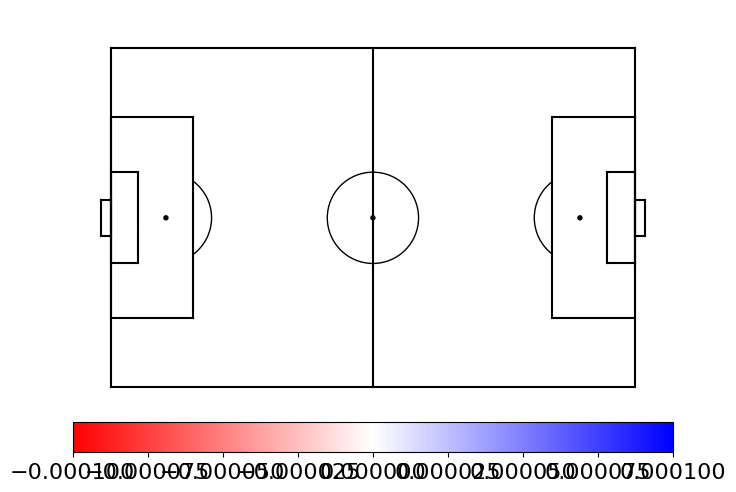

cross 2


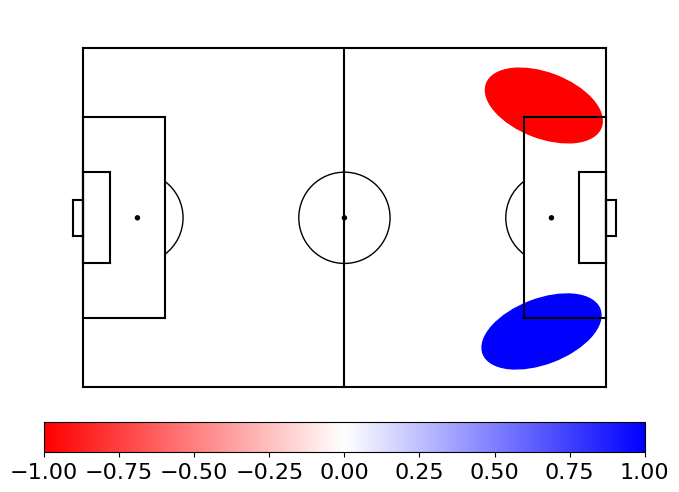

clearance 1


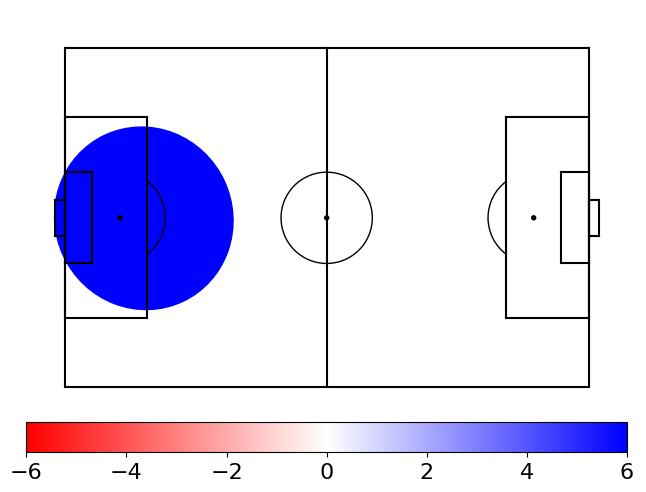

tackle 2


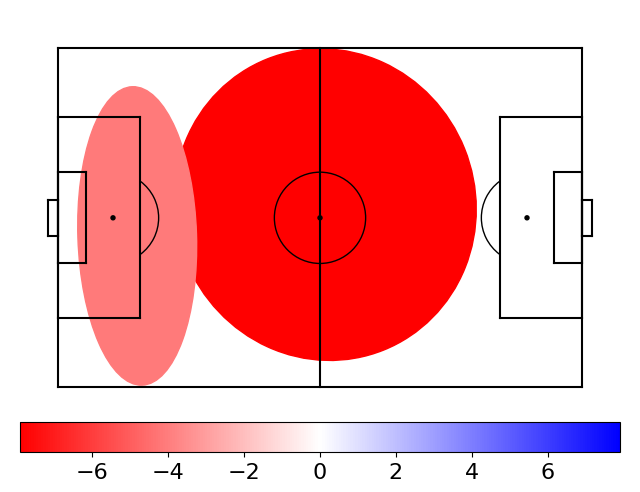

foul 1


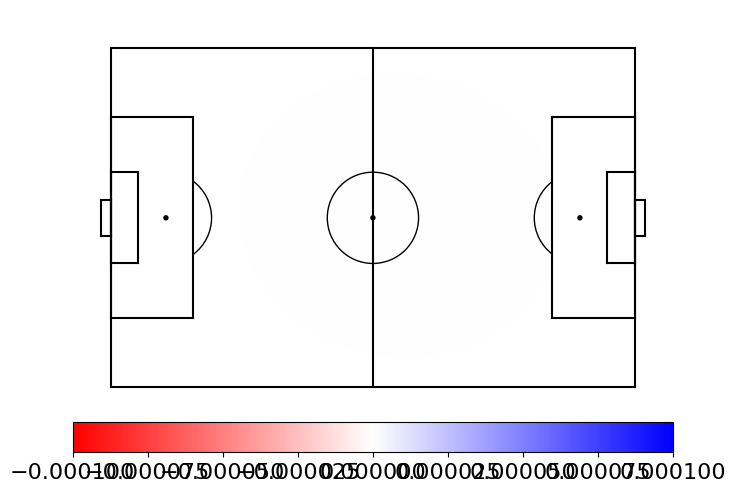

corner 2


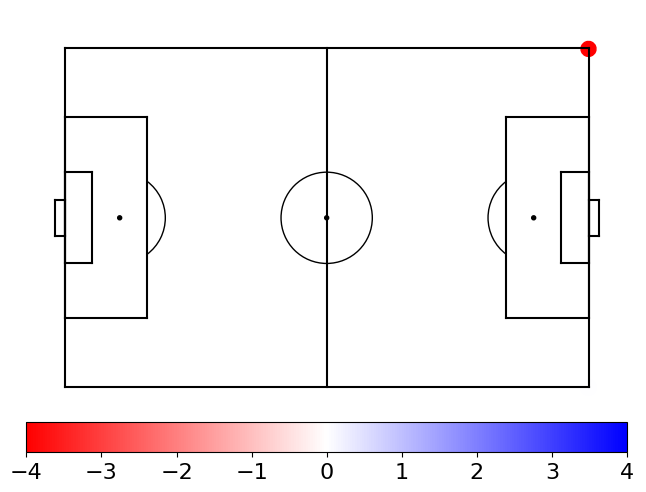

freekick 2


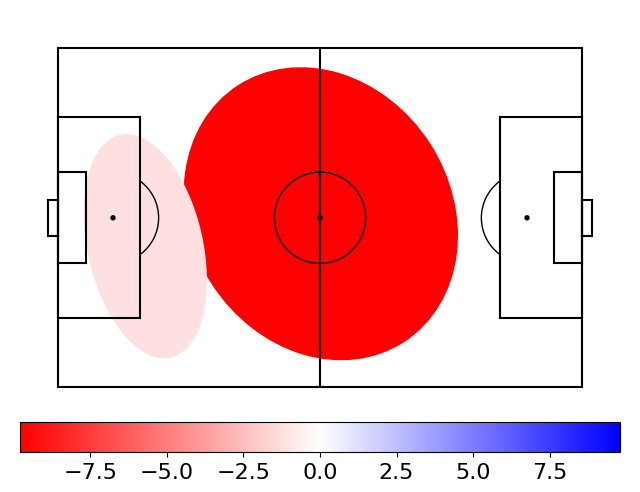

bad_touch 1


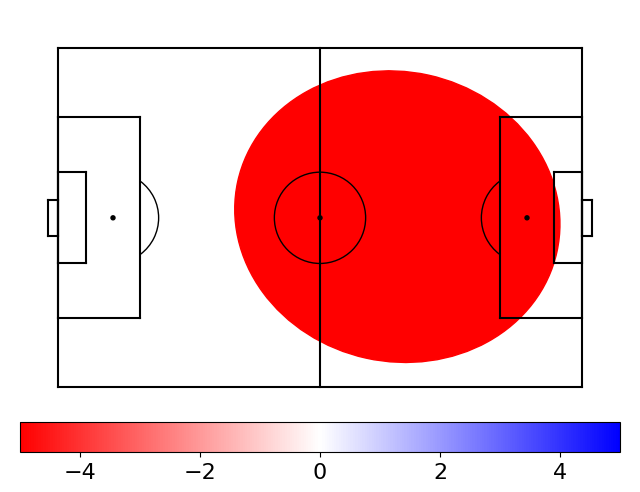

pass 7
pass_0 4
pass_1 1
pass_2 2
pass_3 2


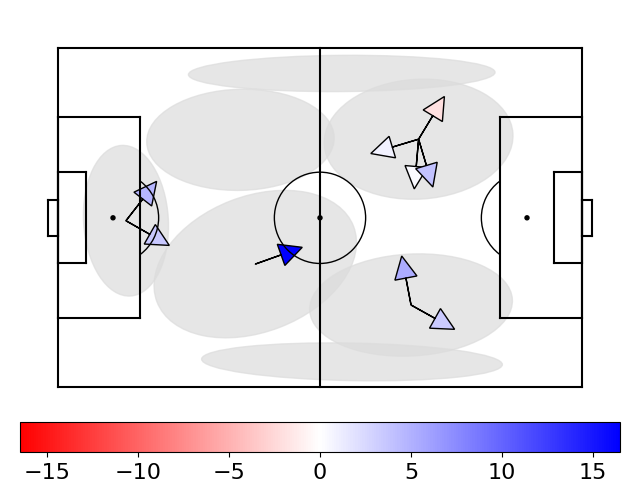

shot 1


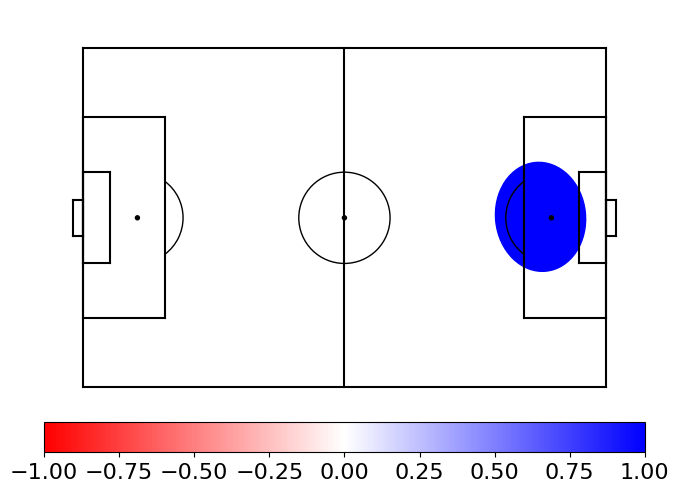

shot_penalty 1


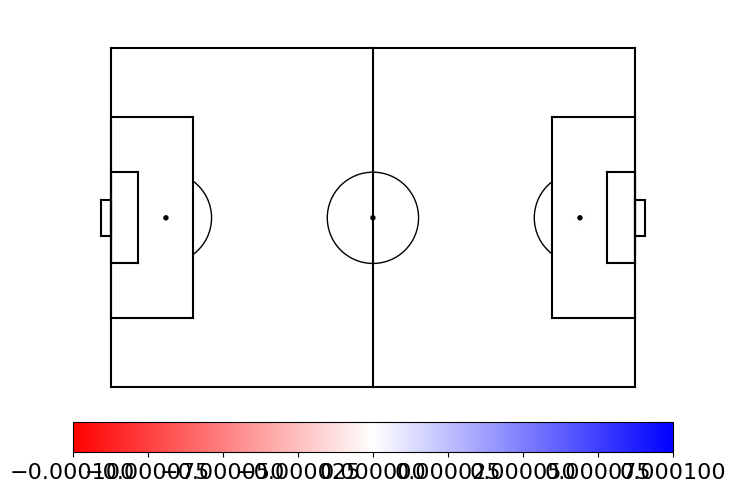

dribble 7
dribble_0 1
dribble_1 1
dribble_2 1
dribble_3 2
dribble_4 3
dribble_5 2
dribble_6 1


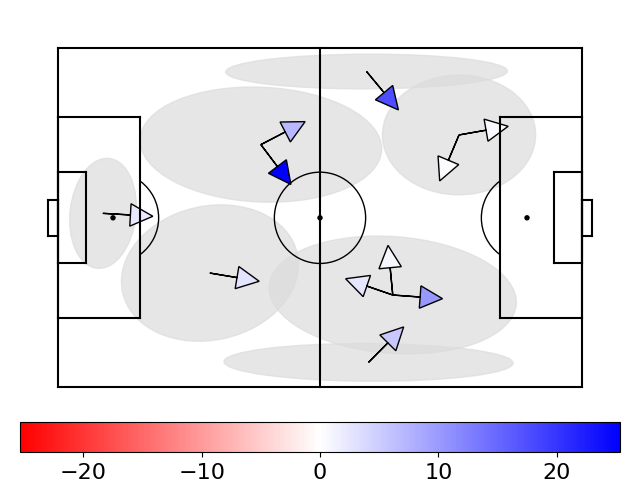

keeper_catch 6
keeper_catch_0 3
keeper_catch_1 2
keeper_catch_2 1
keeper_catch_3 1
keeper_catch_4 2


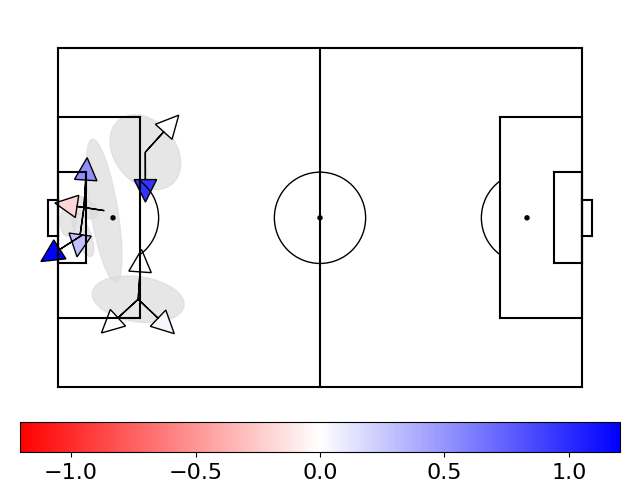

interception 2


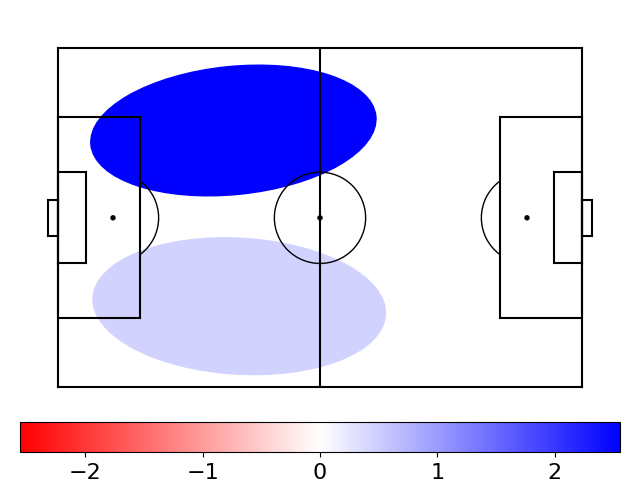

take_on 1


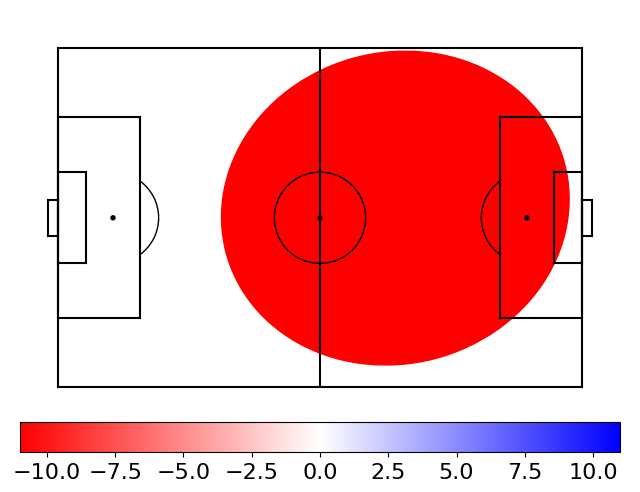

throw_in 2
throw_in_0 1
throw_in_1 2


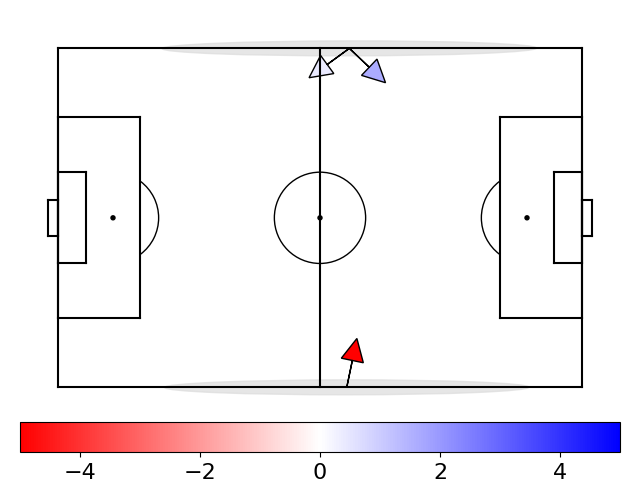

In [20]:
'''
비셀 고베 vs 산프레체 히로시마
비셀 고베가 산프레체 히로시마를 상대할 때 홈과 원정에서 전술적으로 무엇이 달라지는가를 시각화
difference = vec_p1(원정) - vec_p2(홈)
파란색 = vec_p1에서 더 강조하는 전술 행동
'''
vis.show_component_differences(loc_models, dir_models, vectors_pd.loc['1886_1889_2'], vectors_pd.loc['1886_1889_0'], '비셀 고베', '산프레체 히로시마', save=False)


### How did Vissel Kobe play differently the away game against city (win) vs any other game?

goalkick 1


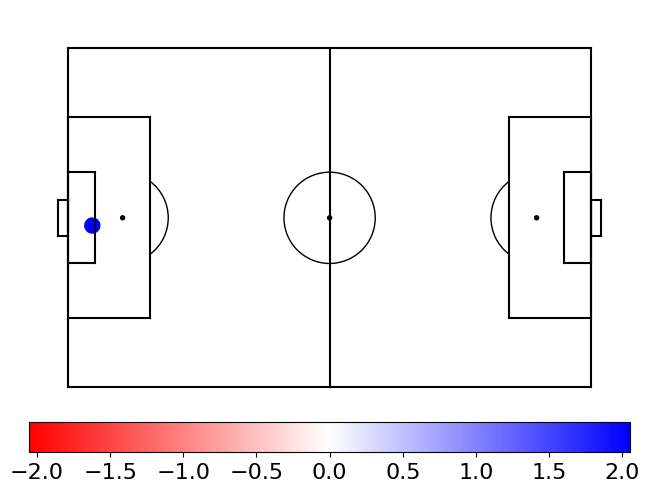

cross 2


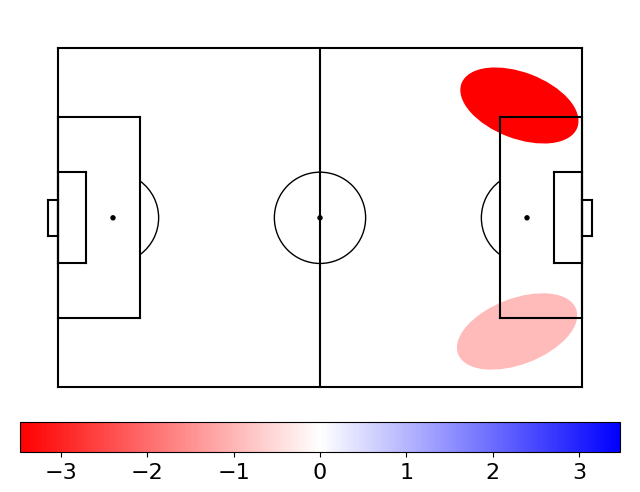

clearance 1


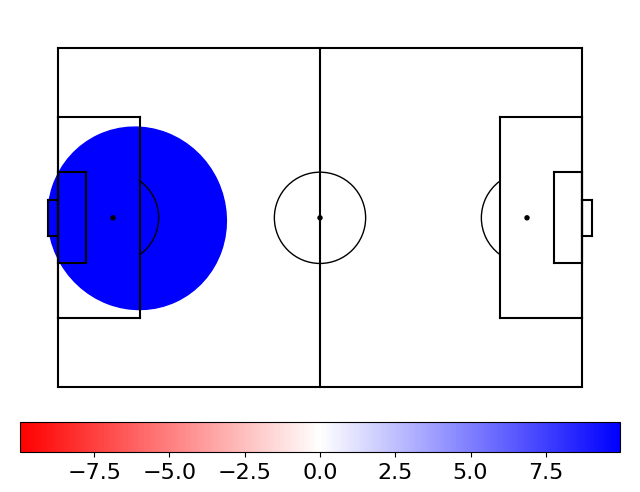

tackle 2


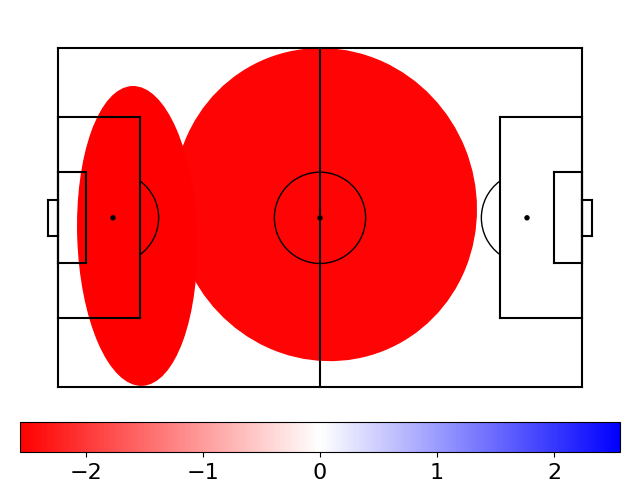

foul 1


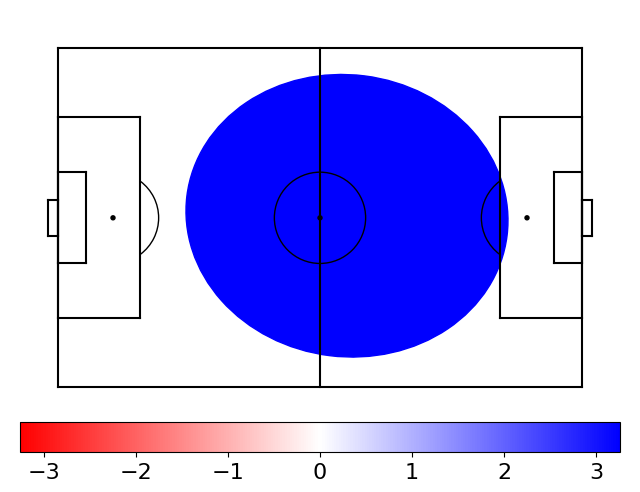

corner 2


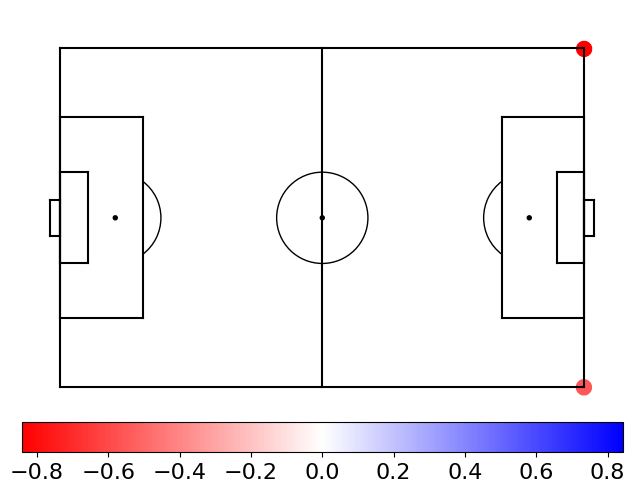

freekick 2


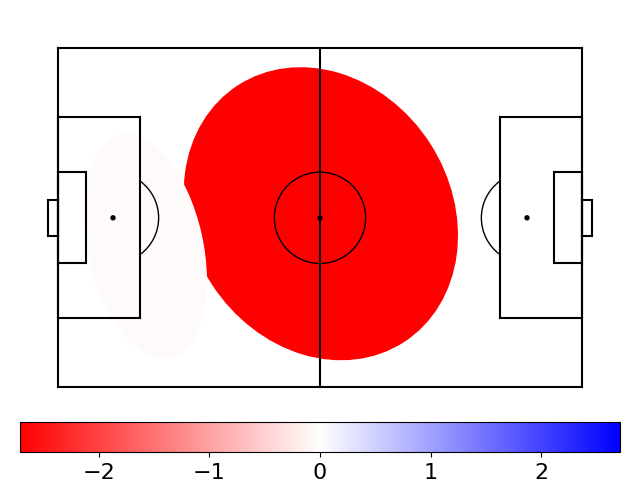

bad_touch 1


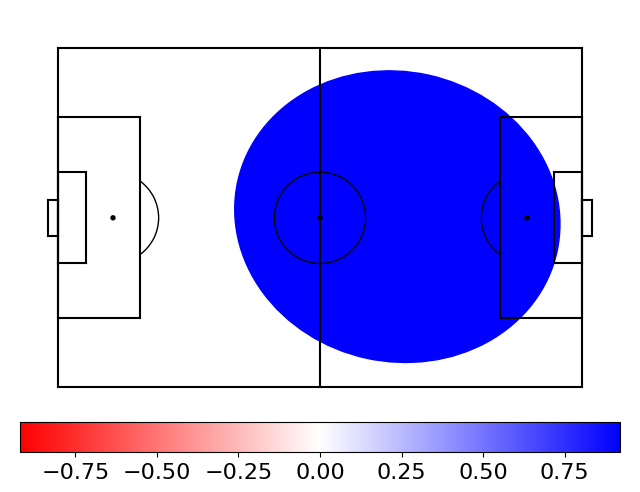

pass 7
pass_0 4
pass_1 1
pass_2 2
pass_3 2


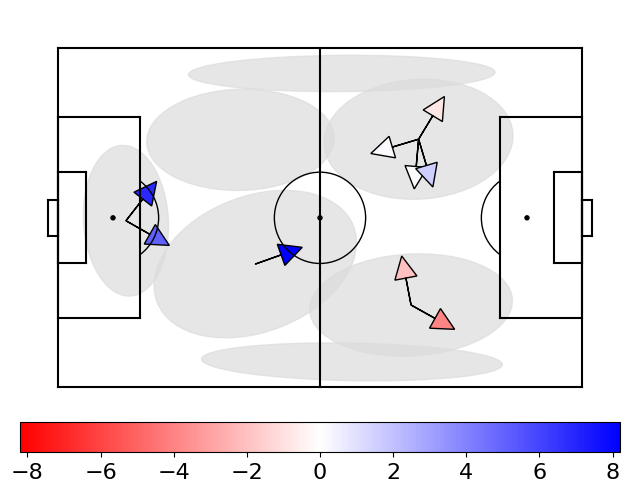

shot 1


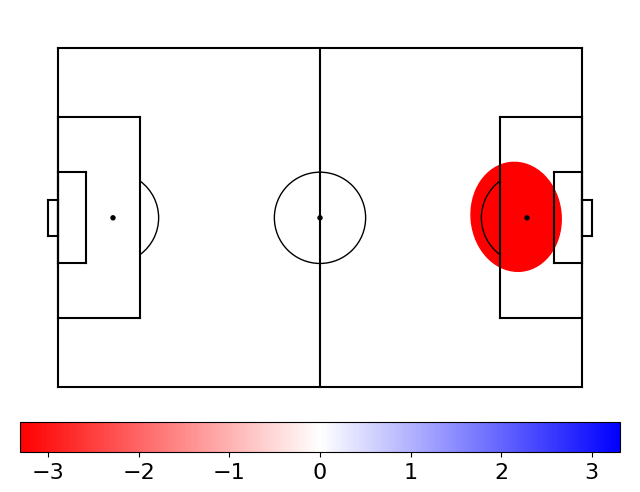

shot_penalty 1


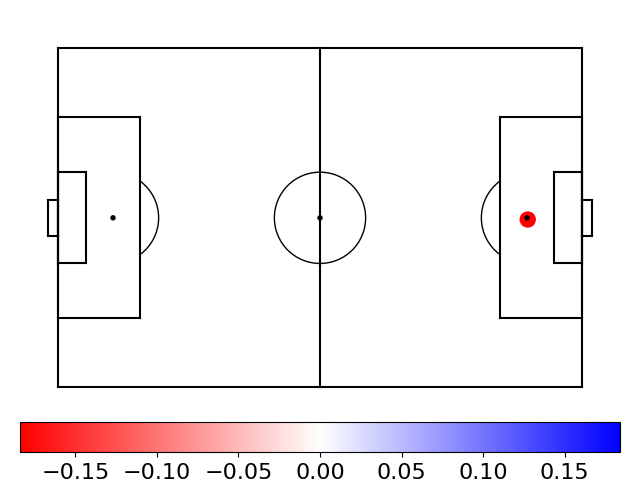

dribble 7
dribble_0 1
dribble_1 1
dribble_2 1
dribble_3 2
dribble_4 3
dribble_5 2
dribble_6 1


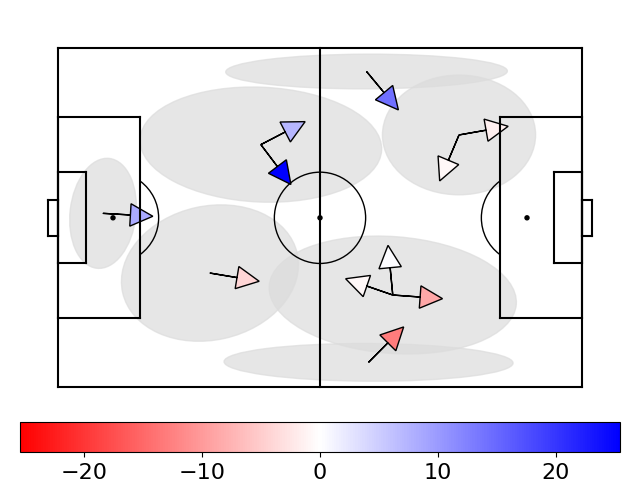

keeper_catch 6
keeper_catch_0 3
keeper_catch_1 2
keeper_catch_2 1
keeper_catch_3 1
keeper_catch_4 2


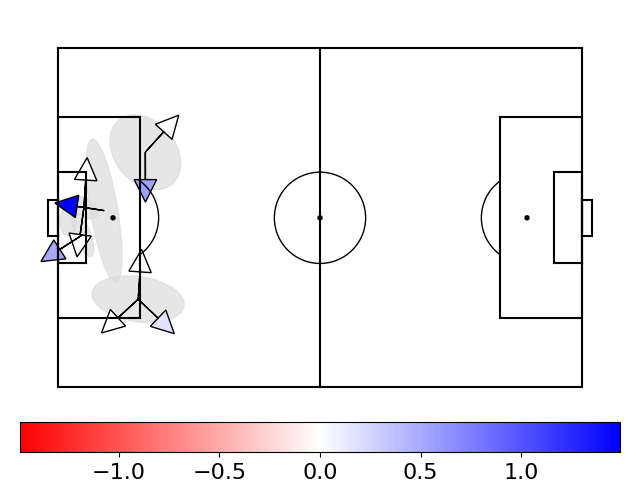

interception 2


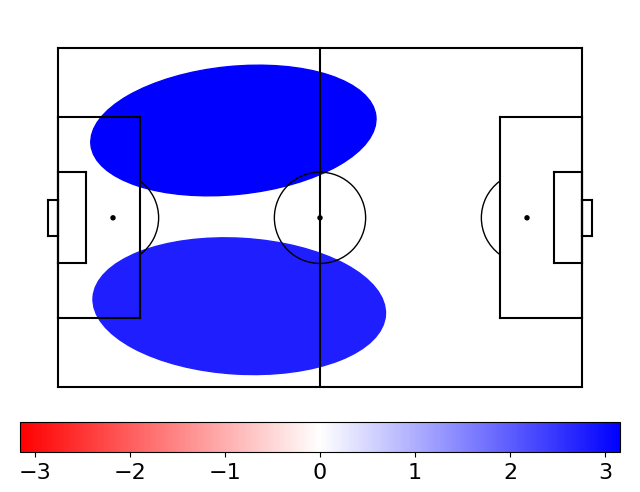

take_on 1


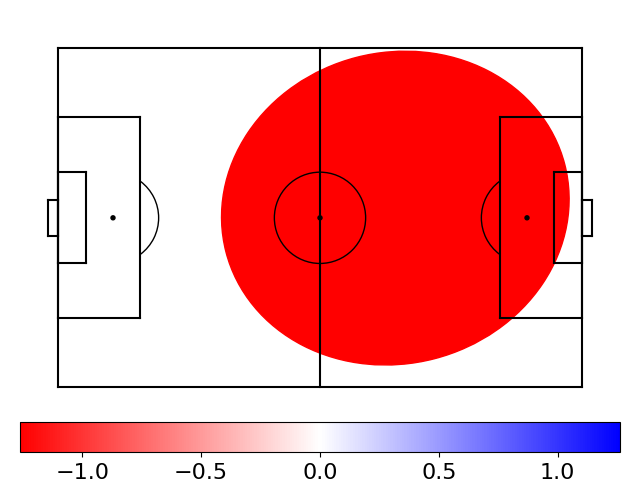

throw_in 2
throw_in_0 1
throw_in_1 2


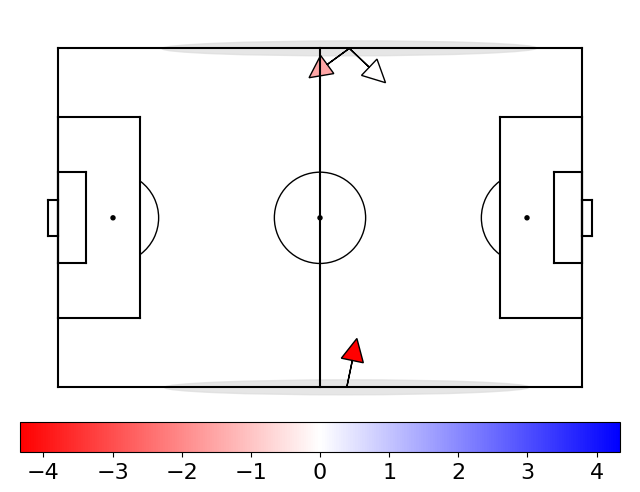

In [21]:
vis.show_component_differences(loc_models, dir_models, vectors_pd.loc['1886_1889_2'], vectors_pd.loc['1886_1889_1'], '비셀 고베', '산프레체 히로시마', save=False)#
# vectors_pd.loc[*_*_1]은 나머지 18개팀과의 경기 분석

# 선수 플레이스타일 분류

In [24]:
games_first_half = games[games.game_day<=19]
games_second_half = games[games.game_day>19]

pg_first = pg[pg.game_id.isin(games_first_half.game_id)]
pg_second = pg[pg.game_id.isin(games_second_half.game_id)]

players_first = players[players.player_id.isin(pg_first.player_id)]
players_second = players[players.player_id.isin(pg_second.player_id)]

mp_first = pg_first[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()
mp_second = pg_second[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

In [25]:
# Get player vectors
# dir_weights : 방향성 기반 Mixture Model 확률 가중치
# 이를 player_id / game_id 단위로 합산하여 전술 특성 벡터로 변환.
# 한 선수가 경기 동안 어떤 전술적 행동을 얼마나 자주 시도했는지를 고차원 벡터로 표현하는 단계
# 시즌을 절반으로 나누어 분류


merged_weights = dir_weights.copy()
merged_weights["player_id"] = X.player_id.values
merged_weights["game_id"] = X.game_id.values

vectors_first = {}
for p in tqdm.tqdm(list(players_first.player_id.unique())):
    vectors_first[int(p)] = merged_weights.loc[((merged_weights.player_id == p)
                                              & (merged_weights.game_id.isin(games_first_half.game_id))),
                                              dir_weights.columns].sum().values

vectors_second = {}
for p in tqdm.tqdm(list(players_second.player_id.unique())):
    vectors_second[int(p)] = merged_weights.loc[((merged_weights.player_id == p)
                                              & (merged_weights.game_id.isin(games_second_half.game_id))),
                                              dir_weights.columns].sum().values

vectors_first_pd = pd.concat({k: pd.DataFrame(v).T for k,v in vectors_first.items()}).droplevel(level=1)
vectors_first_pd.index.name = "player_id"
vectors_first_pd.columns = dir_weights.columns

vectors_second_pd = pd.concat({k: pd.DataFrame(v).T for k,v in vectors_second.items()}).droplevel(level=1)
vectors_second_pd.index.name = "player_id"
vectors_second_pd.columns = dir_weights.columns

100%|██████████| 523/523 [00:27<00:00, 19.19it/s]


In [26]:
# Normalize vectors per 90 min game time

vectors_first_norm = pd.merge(vectors_first_pd, mp_first, left_index=True, right_on='player_id').set_index('player_id')
df1 = vectors_first_norm.loc[:, dir_weights.columns] * 90
vectors_first_norm.loc[:, dir_weights.columns] = df1.divide(vectors_first_norm.minutes_played, axis='rows')
vectors_first_norm.drop(columns=['minutes_played'], inplace=True)

vectors_second_norm = pd.merge(vectors_second_pd, mp_second, left_index=True, right_on='player_id').set_index('player_id')
df1 = vectors_second_norm.loc[:, dir_weights.columns] * 90
vectors_second_norm.loc[:, dir_weights.columns] = df1.divide(vectors_second_norm.minutes_played, axis='rows')
vectors_second_norm.drop(columns=['minutes_played'], inplace=True)

/tmp/ipython-input-1471048898.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[4.7368421052631575, 0.0, 0.33088235294117646, 0.9076433121019108, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06060606060606061, 0.27607361963190186, 0.0, 0.0, 0.14453961456102785, 0.050933786078098474, 0.0, 0.0, 0.0, 0.0, 0.8074162679425837, 0.0, 7.211538461538462, 0.19230769230769232, 0.4161849710982659, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.605889014722536, 0.06020066889632107, 0.0, 0.14434643143544507, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.9456579648375065, 0.0, 0.2876931273308471, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.523809523809524, 0.0, 1.7635135135135136, 0.10044642857142858, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.553571428571429, 0.0, 0.10778443113772455, 0.8866995073891626, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.651515151515151, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.13

In [27]:
# Code below mainly from Pieter's implementation of this experiment with soccer vectors
# https://github.com/probberechts/soccer-player-vectors-thesis/blob/master/notebooks/5-experiments.ipynb

# Select correct players to test on

train_players = pg_first.groupby('player_id').agg({
    'minutes_played': 'sum',
    'team_id': set
}).merge(players, on="player_id", how='left')

test_players = pg_second.groupby('player_id').agg({
    'minutes_played': 'sum',
    'team_id': set
}).merge(players, on="player_id", how='left')

In [29]:
all_players = pd.merge(train_players, test_players, on="player_id", suffixes=("_train", "_test"))
all_players['nb_teams'] = all_players.apply(lambda x: len(x.team_id_train | x.team_id_test), axis=1)
all_players = all_players[all_players.nb_teams == 1]
# Only players who played >= 900 minutes in both train and test season
all_players = all_players[(all_players.minutes_played_train >= 500) & (all_players.minutes_played_test >= 500)]
all_players = all_players.player_id.unique()
print("Number of players: ", len(all_players))

Number of players:  230


In [33]:
# Compute pairwise distances
# 모든 선수 간 전반기 vs 후반기 임베딩 거리 행렬 D 계산
#    - L1 거리(Manhattan) + L1 normalization 적용
from sklearn.metrics import pairwise_distances
from sklearn import preprocessing

D = pairwise_distances(
    preprocessing.normalize(vectors_first_norm.loc[all_players].sparse.to_dense().fillna(0), norm="l1"),
    preprocessing.normalize(vectors_second_norm.loc[all_players].sparse.to_dense().fillna(0), norm="l1"),
    metric="manhattan"
)

# sort each row
k_d = np.sort(D, axis = 1)
# sort each row and replace distances by index
k_i = np.argsort(D, axis = 1)
# replace indices by player ids
p_i = np.take(all_players, k_i, axis = 0)

In [34]:
rs = np.argmax(np.array([p_i[i,:] == all_players[i] for i in range(p_i.shape[0])]), axis=1)
rs

array([  3,   0,   4,  35,   3,   1,   3,   1,  41,  20,   0,   2,   0,
         0,   0,   0,   0,   0,   0,  10,   0,   0,   1,   1,   0,   5,
         0,  32,   0,   3,  31,   2,   2,   0,   0,  60,   3,   0,  32,
         0,   0,  89,   5,  21,   0,   0,   0,   0,  14,   0,   0,   2,
         0,   0,  19,   0,   0,   5,   0,   1,  13,   9,   0,   0,   0,
        20,   2,   6,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,
        19,   2,  10,   0,   6,   0,  14,   4,   0,   1,   0,   4,   0,
        11,  24,  13,   0,  15,   1,   0,  16,   1,  14,   0,   1,   4,
         0,   0,  33,   2,   0,   4,   1,  11,   0,   0,   0,   0,   1,
         0,   1,  33,   7,   0,   2,  26,   2,  19,  21,   0,  26,   0,
         5,   0,   0,   0,   0,   0,  12,  14,   3,   0,   4,  73,   2,
         7,   2,   1,   9,   0,   1,  10,   6,   0,   0,   6,   0,   5,
         0, 128,   2,   6,   0,   0,   1,   3,   0,   2,   2, 119,   0,
         0,  11,   0,   5,   0,   6,   0,   0,   6,   1,   0,   

In [35]:
# 각 선수(행)의 거리 순위 기반으로:
#    - 동일 선수(Self) 위치의 순위(rs) 계산, 선수 본인을 얼마나 상위에 놔두는지 성능 측정
def mean_reciprocal_rank(rs):
    return np.mean(1. / (rs + 1))

def top_k(rs, k):
    return (rs < k).sum() / len(rs)

In [36]:
mean_reciprocal_rank(rs)

0.5614160462152109

In [38]:
print(top_k(rs, 10))
print(top_k(rs, 5))
print(top_k(rs, 3))
print(top_k(rs, 1))

0.8043478260869565
0.6782608695652174
0.6173913043478261
0.44782608695652176


### Get similar players to player

In [39]:
def get_similar_players(player_id):
    player_index = np.where(all_players == player_id)[0][0]
    print(player_index)
    sims = p_i[player_index,:]
    names = players_first.set_index("player_id").loc[sims, "player_name"].values
    dists = k_d[player_index,:]
    return pd.DataFrame({"name": names, "dist": dists})

In [40]:
train_players[train_players['player_id']==37655]

player_id  minutes_played team_id      player_name         nickname
130      37655            1390  {1891}  Lucas Fernandes  Lucas Fernandes

In [41]:
'''
2024 J1 League 평점 1위 Lucas Fernandes(세레소 오사카)
2024 J1 League MVP, J1리그 베스트 일레븐 Yoshinori Muto(비셀 고베)
'''
print(train_players[train_players.player_name.str.contains('Lucas')].player_id)
print(train_players[train_players.player_name.str.contains('Yoshinori M')].player_id)


130    37655
Name: player_id, dtype: int64
9    6337
Name: player_id, dtype: int64


In [42]:
get_similar_players(37655) # Similar to Lucas Fernandes

58


name      dist
0             Lucas Fernandes  0.257994
1                Kazuya Konno  0.346657
2              Yoshinori Muto  0.376627
3    Yan Matheus Santos Souza  0.385541
4               Tomoaki Okubo  0.414326
..                        ...       ...
225           Takanori Sugeno  1.745433
226           Sung-Ryong Jung  1.748022
227              William Popp  1.749286
228         Shusaku Nishikawa  1.751419
229            Ryosuke Kojima  1.756863

[230 rows x 2 columns]

In [43]:
get_similar_players(6337) # Similar to Yoshinori Muto

5


name      dist
0    Marco Túlio Oliveira Lemos  0.137870
1                Yoshinori Muto  0.175333
2              Tomoya Koyamatsu  0.287438
3              Masaya Shibayama  0.304602
4                   Shu Morooka  0.312246
..                          ...       ...
225             Takumi Nagaishi  1.718661
226            Masaaki Murakami  1.721538
227               Bum-Keun Song  1.728602
228             Sung-Ryong Jung  1.736548
229           Shusaku Nishikawa  1.738379

[230 rows x 2 columns]

# 선수별 전술 특성 벡터 생성 및 포지션 대응

In [44]:
# dir_weights를 선수 단위로 집계하여 각 선수의 "전술 행동 시그니처 벡터"를 만듬
vectors = {}

for p in tqdm.tqdm(list(mp.player_id.unique())):
    vec = merged_weights.loc[merged_weights.player_id == p, dir_weights.columns].sum().values
    vectors[int(p)] = vec

100%|██████████| 585/585 [00:45<00:00, 12.87it/s]


In [46]:
vectors_pd = pd.concat({k: pd.DataFrame(v).T for k,v in vectors.items()}).droplevel(level=1)
vectors_pd.index.name = "player_id"
vectors_pd.columns = dir_weights.columns

In [47]:
## Normalize vectors for minutes played

vectors_pd_norm = pd.merge(vectors_pd, mp, left_index=True, right_on='player_id').set_index('player_id')
vectors_pd_norm = vectors_pd_norm[vectors_pd_norm.minutes_played > 900]
df1 = vectors_pd_norm.loc[:, dir_weights.columns] * 90
vectors_pd_norm.loc[:, dir_weights.columns] = df1.divide(vectors_pd_norm.minutes_played, axis='rows')
vectors_pd_norm.drop(columns=['minutes_played'], inplace=True)

/tmp/ipython-input-2655781000.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[8.271334792122538, 0.0, 0.24258760107816713, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.059366754617414245, 0.0, 0.09566834972096731, 0.0, 1.361344537815126, 0.0, 0.45646661031276414, 0.20785219399538107, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3604325190228274, 0.0, 6.972555746140652, 0.0, 0.0, 0.2842853382469071, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.9468267581475125, 0.0, 0.0, 0.0, 0.0, 0.4644700277888051, 0.0, 0.0, 0.0906801007556675, 0.0, 0.0, 0.0, 0.0, 6.421348314606742, 0.0, 5.505709624796085, 0.0, 0.1761252446183953, 0.0, 0.0, 0.0, 0.0, 0.0, 8.224137931034482, 0.0, 7.75494071146245, 0.0, 0.0, 0.0, 0.20179372197309417, 0.0, 0.0, 0.0, 6.183206106870229, 0.0, 0.16129032258064516, 0.6699751861042184, 0.0, 0.0, 0.680161943319838, 0.0, 0.02880921895006402, 0.0, 7.913043478

In [48]:
# Get positions for people with vectors if possible
filled_in_positions = pg[pg.starting_position_name != 0]

people_with_vector = vectors_pd_norm.index.values
people_with_position = filled_in_positions.player_id.unique()

people = set(people_with_position).intersection(set(people_with_vector))

In [49]:
players_ = list(people)
player_positions = pd.DataFrame(data={'player_id': players_}, columns=['player_id', 'position'])

for pl in players_:
    vc = filled_in_positions.loc[filled_in_positions.player_id == pl].starting_position_name.value_counts()
    player_positions.loc[player_positions.player_id == pl, ['position']] = vc.index[0]

### Player Comparison

In [50]:
print(players[players.player_name.str.contains('Lucas Fernandes')].player_id) # 2024 J1 League 평점 1위 Lucas Fernandes(세레소 오사카)
print(players[players.player_name.str.contains('Yoshinori M')].player_id) # 2024J1 League MVP, J1리그 베스트 일레븐 Yoshinori Muto(비셀 고베)

195    37655
Name: player_id, dtype: int64
119    6337
Name: player_id, dtype: int64


In [51]:
print(player_positions[player_positions.player_id == 37655])
print(player_positions[player_positions.player_id == 6337])

     player_id    position
128      37655  Right Wing
    player_id    position
23       6337  Right Wing


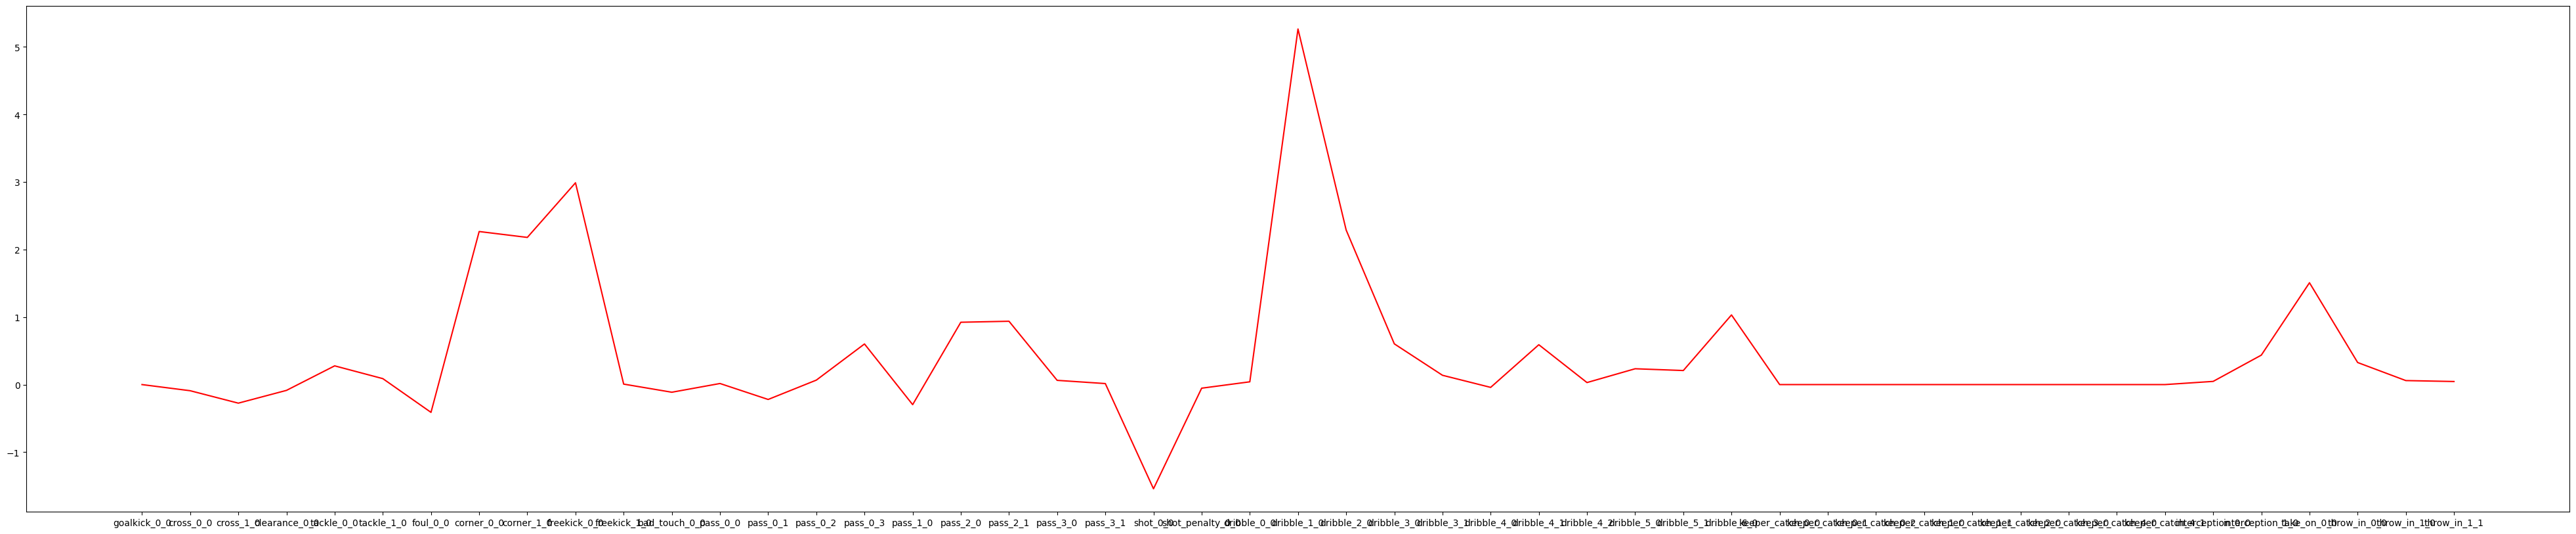

In [53]:
import matplotlib.pyplot as plt
# Difference between Lucas Fernandes and Yoshinori Muto
plt.figure(figsize=(50,10))
plt.plot(vectors_pd_norm.columns.values, vectors_pd_norm.loc[37655] - vectors_pd_norm.loc[6337],'r')

goalkick 1


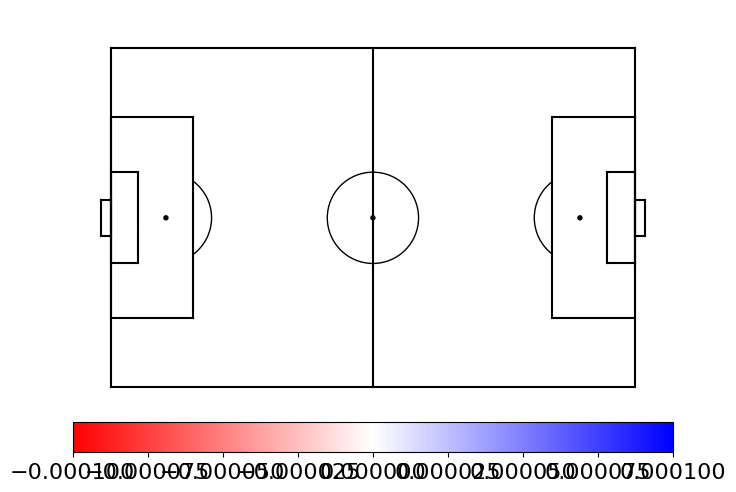

cross 2


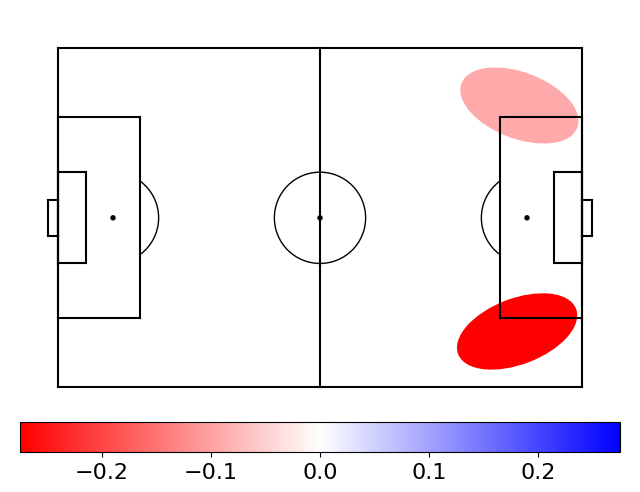

clearance 1


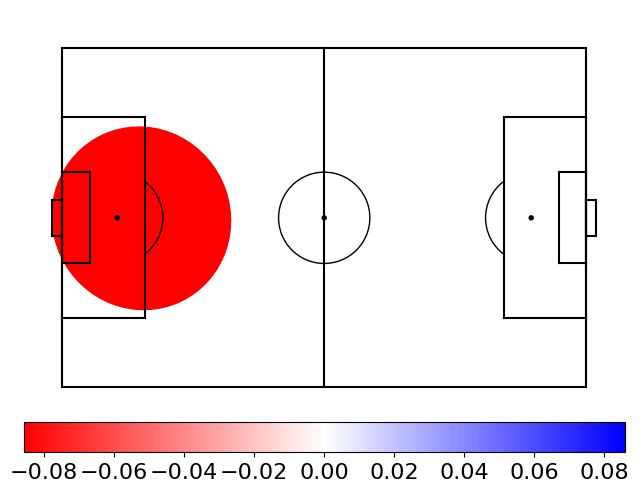

tackle 2


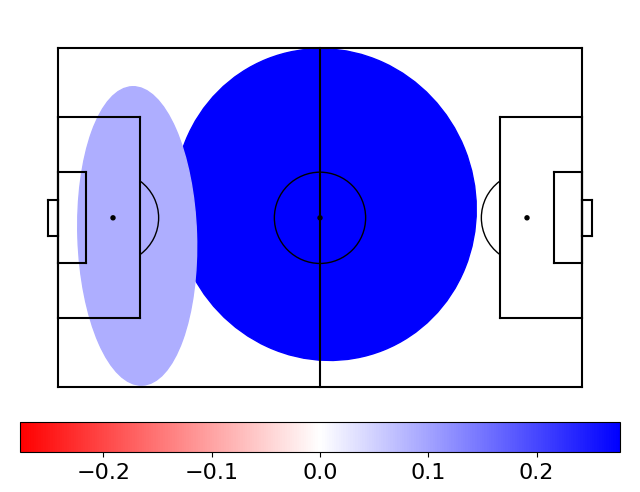

foul 1


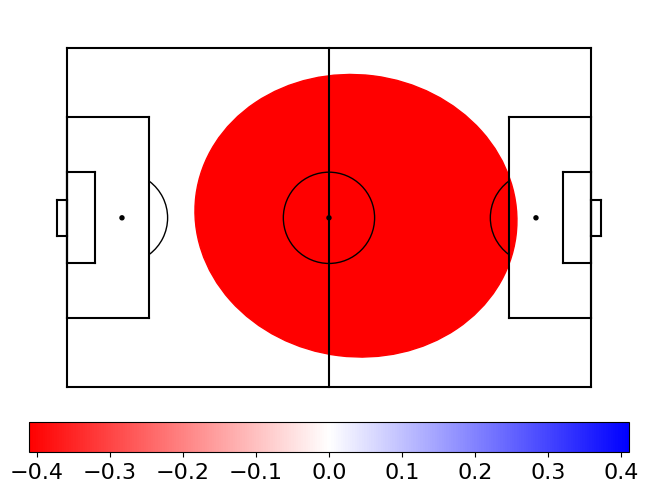

corner 2


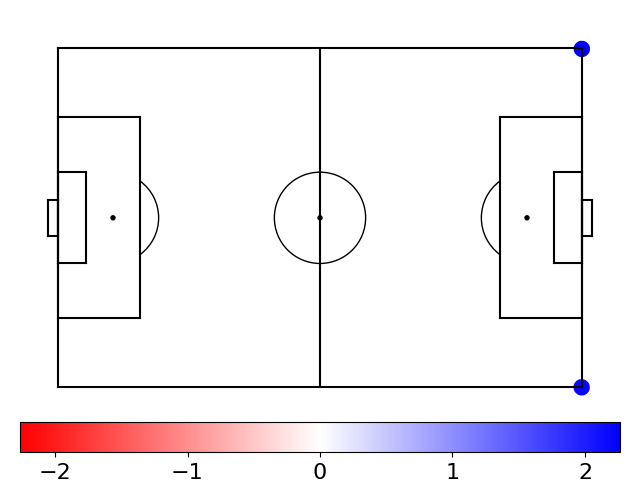

freekick 2


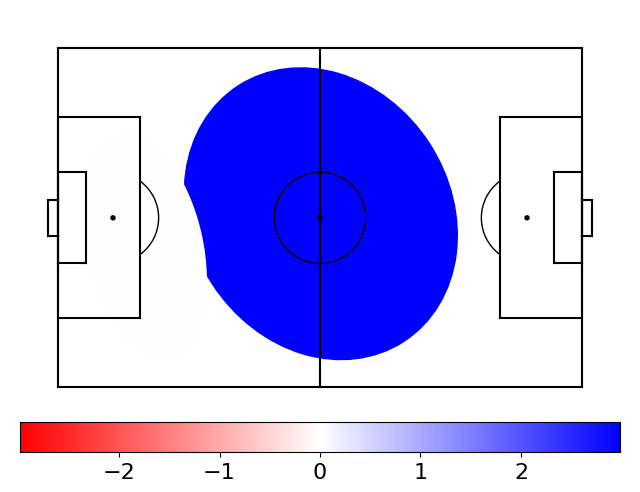

bad_touch 1


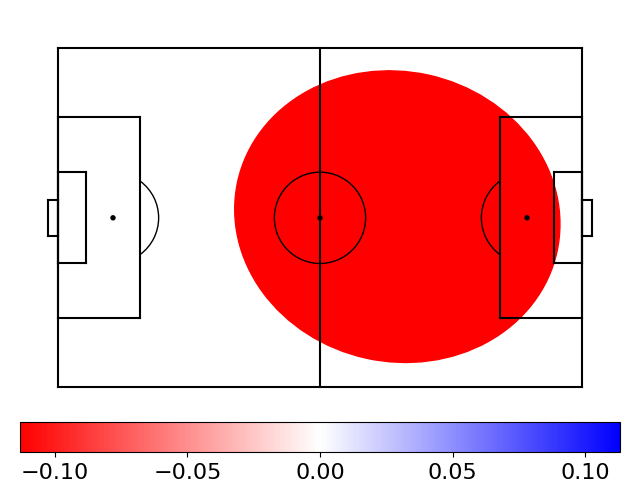

pass 7
pass_0 4
pass_1 1
pass_2 2
pass_3 2


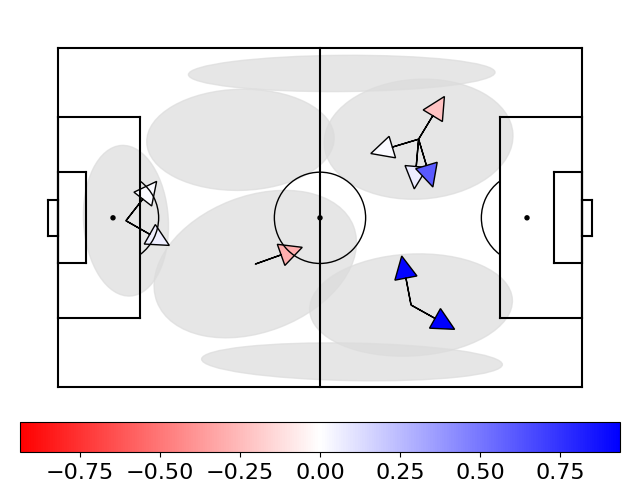

shot 1


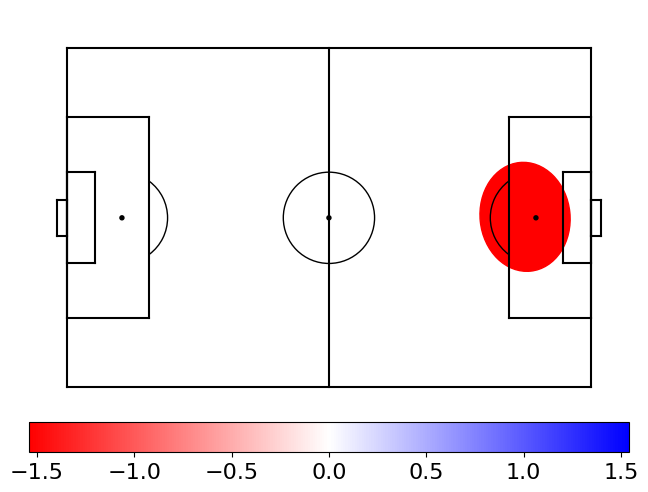

shot_penalty 1


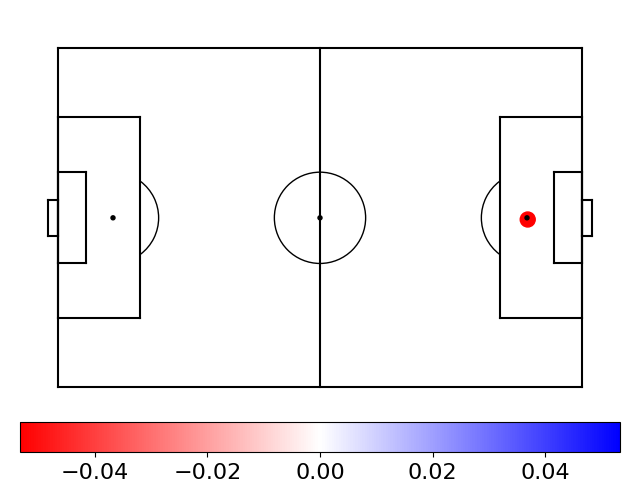

dribble 7
dribble_0 1
dribble_1 1
dribble_2 1
dribble_3 2
dribble_4 3
dribble_5 2
dribble_6 1


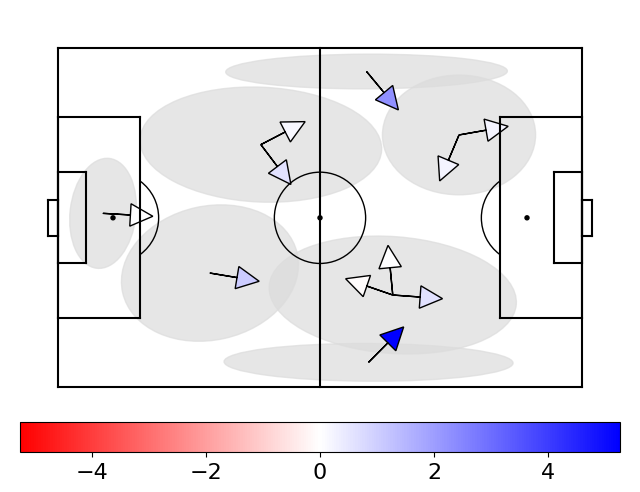

keeper_catch 6
keeper_catch_0 3
keeper_catch_1 2
keeper_catch_2 1
keeper_catch_3 1
keeper_catch_4 2


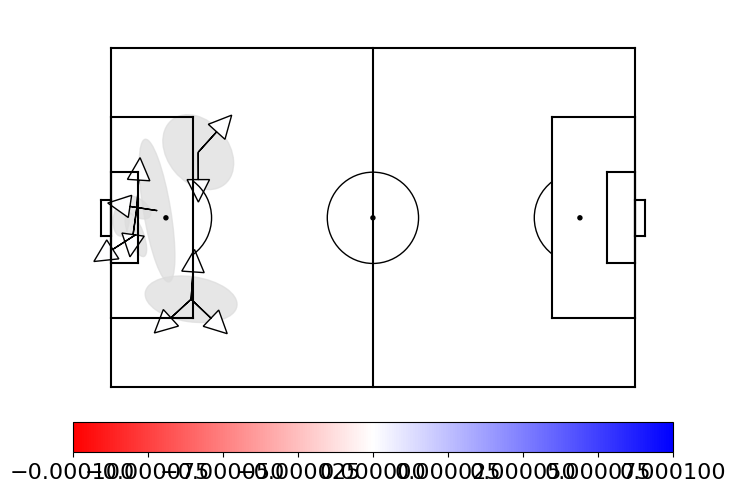

interception 2


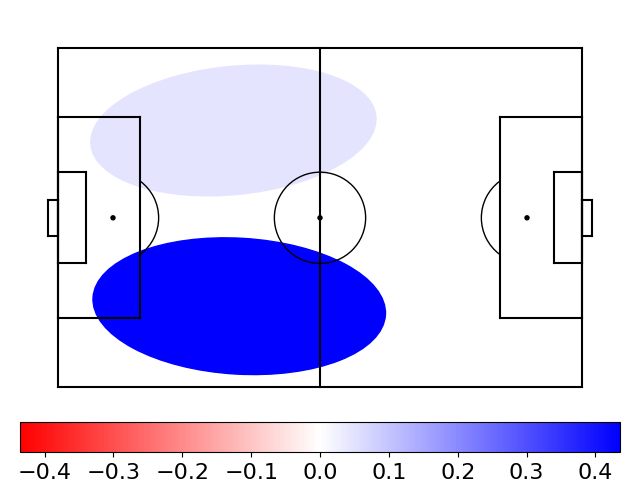

take_on 1


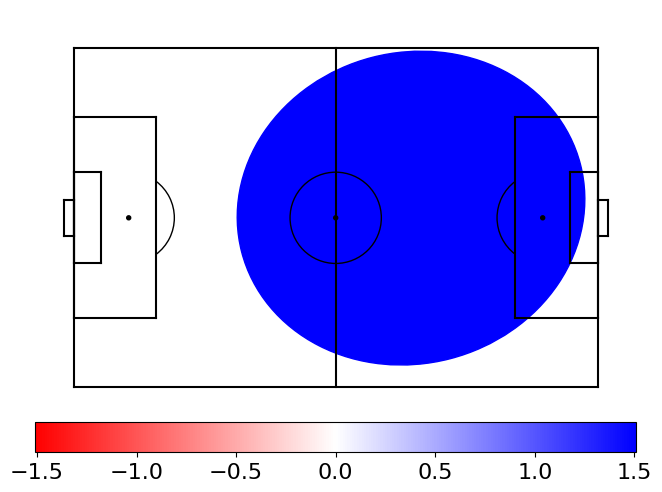

throw_in 2
throw_in_0 1
throw_in_1 2


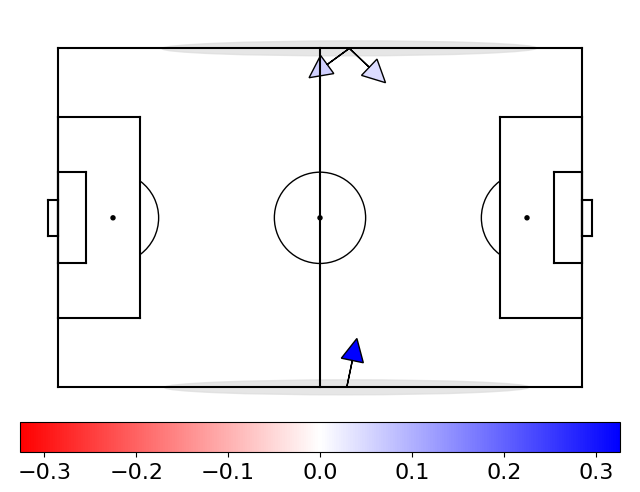

In [54]:
vis.show_component_differences(loc_models, dir_models, vectors_pd_norm.loc[37655], vectors_pd_norm.loc[6337], "Lucas", "Muto", save=False)

# 팀 간 스타일 비교

In [57]:
vectors = {}

for p in tqdm.tqdm(list(games.home_team_id.unique())):
    vec = merged_weights.loc[merged_weights.team_id == p, dir_weights.columns].sum().values
    vectors[int(p)] = vec

100%|██████████| 20/20 [00:02<00:00,  7.96it/s]


In [58]:
vectors_pd = pd.concat({k: pd.DataFrame(v).T for k,v in vectors.items()}).droplevel(level=1)
vectors_pd.index.name = "team_id"
vectors_pd.columns = dir_weights.columns

### Compare teams: Vissel Kobe - Sanfrecce Hiroshima

In [59]:
print(teams[teams.team_name == 'Vissel Kobe'].team_id)
print(teams[teams.team_name == 'Sanfrecce Hiroshima'].team_id)

8    1886
Name: team_id, dtype: int64
11    1889
Name: team_id, dtype: int64


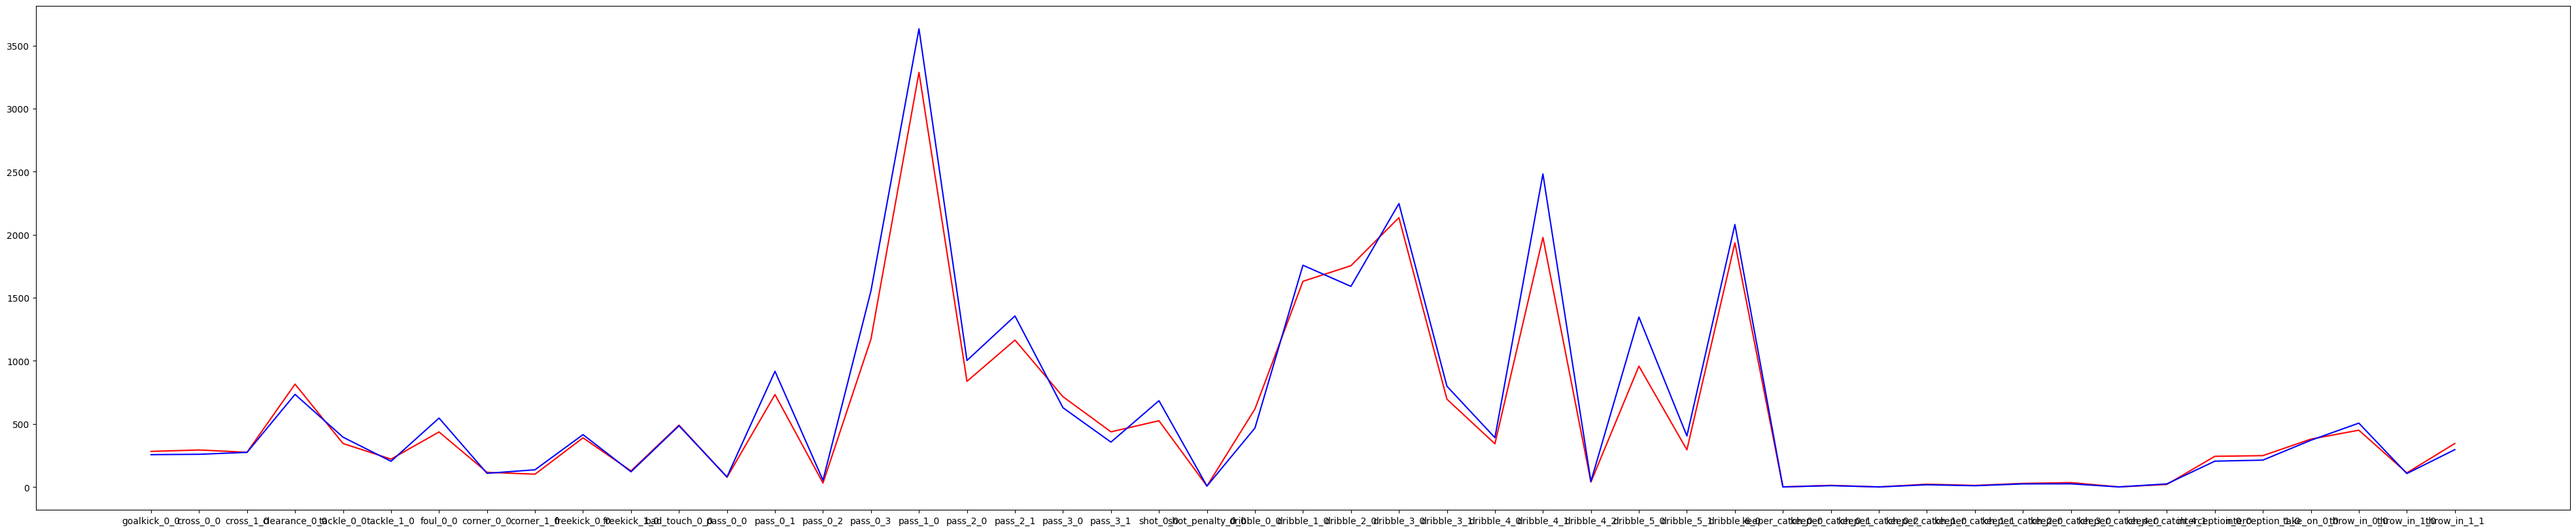

In [60]:
plt.figure(figsize=(50,10))
plt.plot(vectors_pd.columns.values, vectors_pd.loc[1886,:], 'r') # Vissel Kobe
plt.plot(vectors_pd.columns.values, vectors_pd.loc[1889,:], 'b') # Sanfrecce Hiroshima

goalkick 1


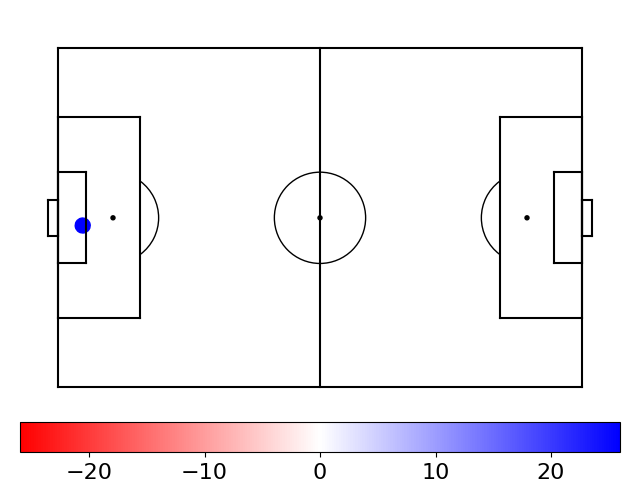

cross 2


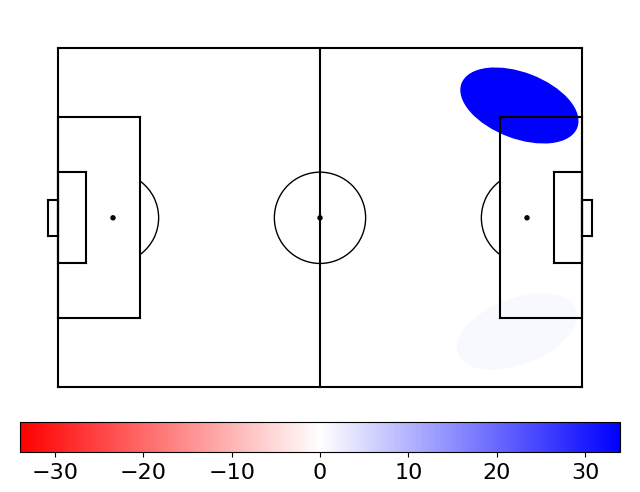

clearance 1


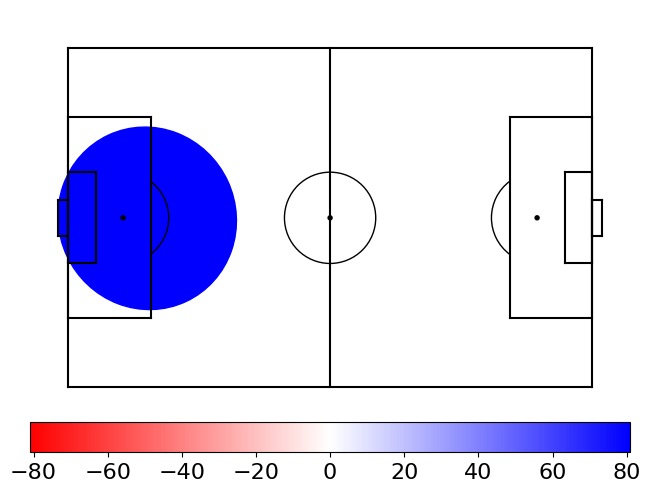

tackle 2


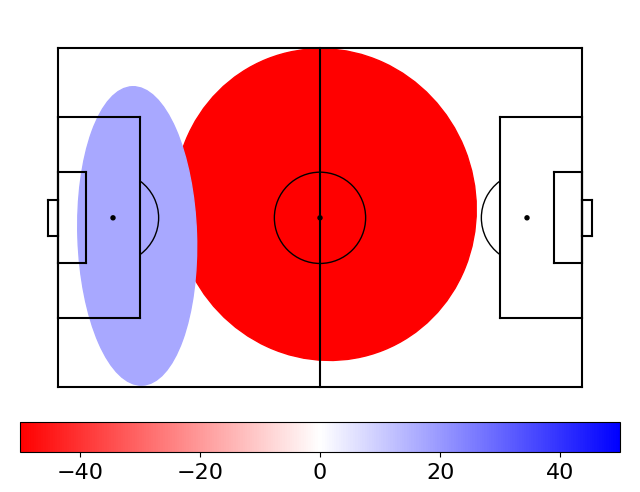

foul 1


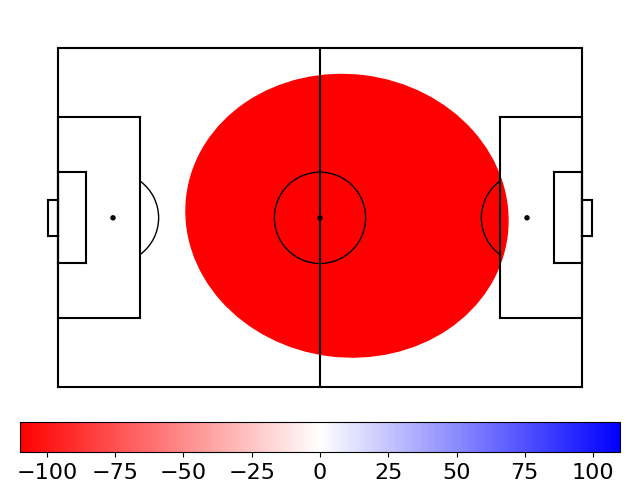

corner 2


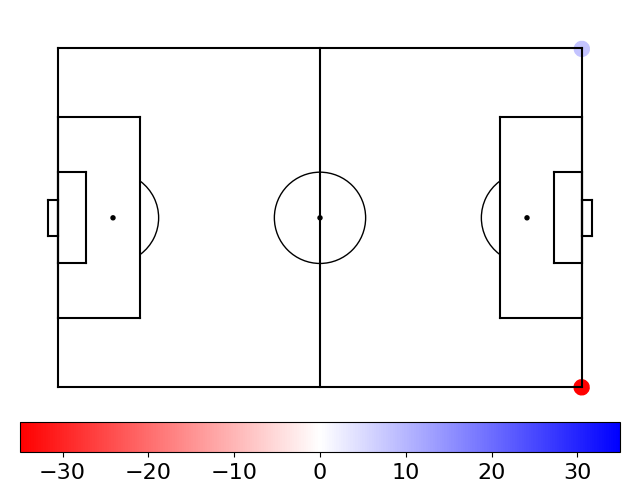

freekick 2


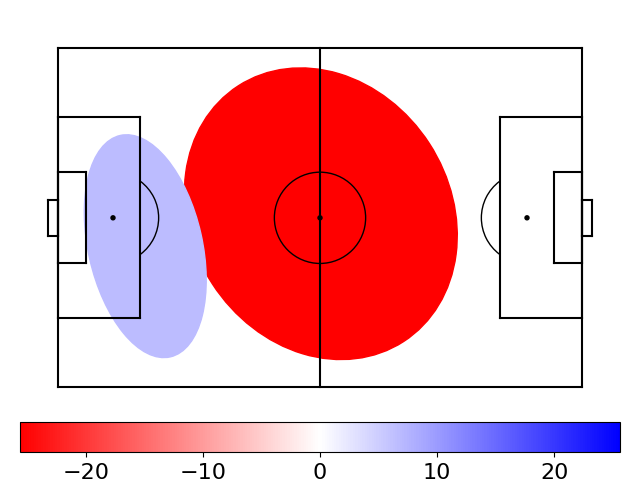

bad_touch 1


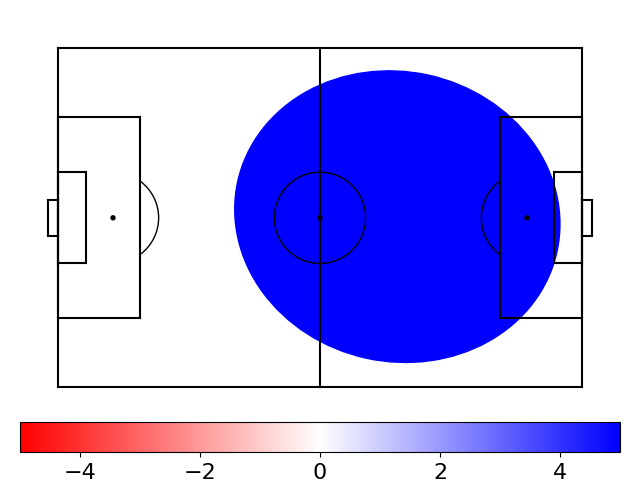

pass 7
pass_0 4
pass_1 1
pass_2 2
pass_3 2


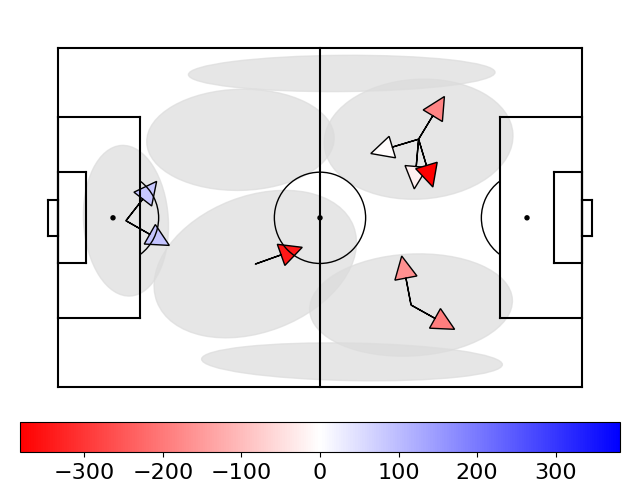

shot 1


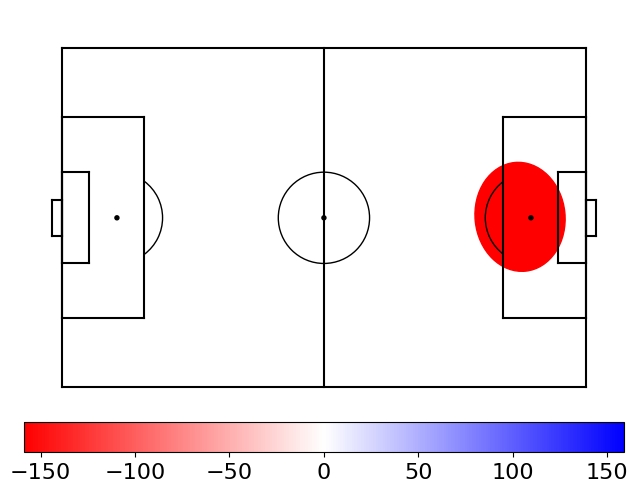

shot_penalty 1


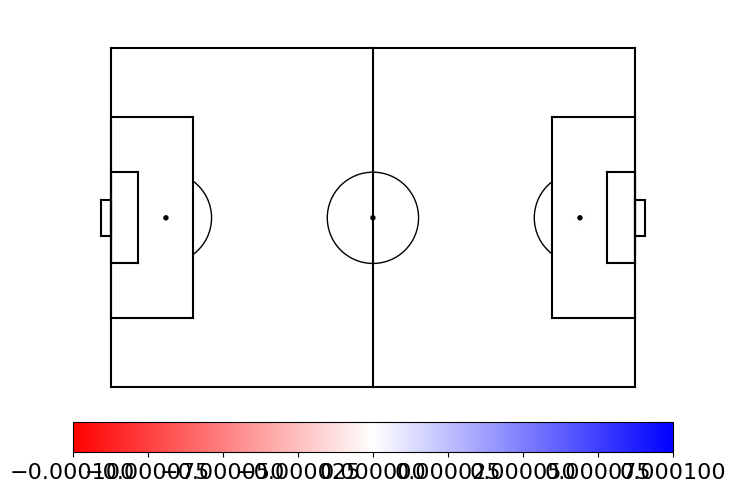

dribble 7
dribble_0 1
dribble_1 1
dribble_2 1
dribble_3 2
dribble_4 3
dribble_5 2
dribble_6 1


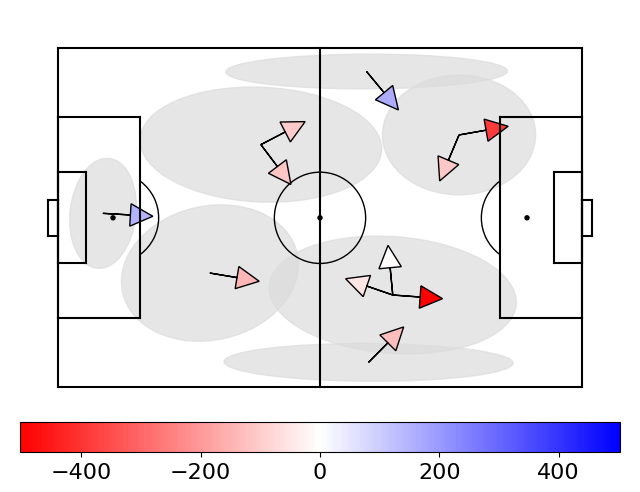

keeper_catch 6
keeper_catch_0 3
keeper_catch_1 2
keeper_catch_2 1
keeper_catch_3 1
keeper_catch_4 2


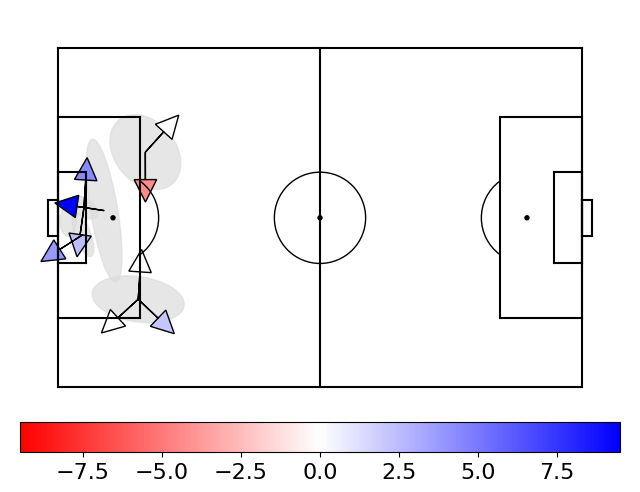

interception 2


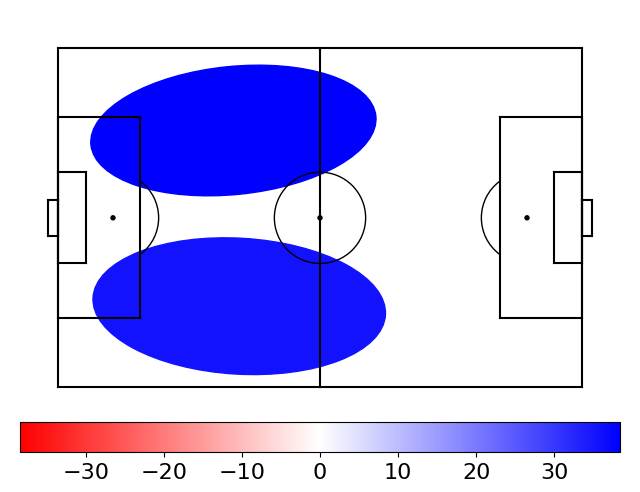

take_on 1


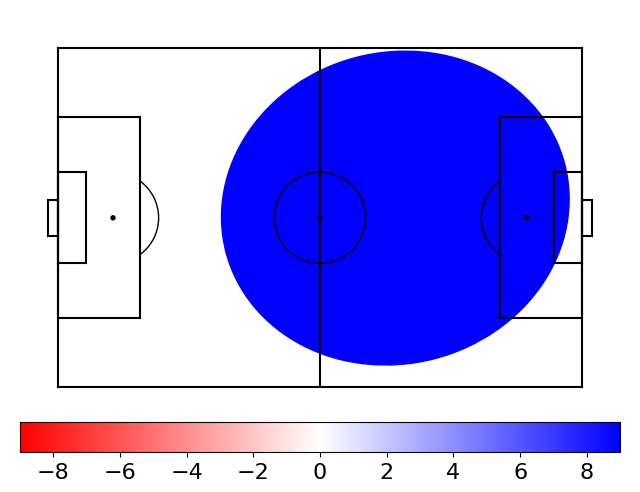

throw_in 2
throw_in_0 1
throw_in_1 2


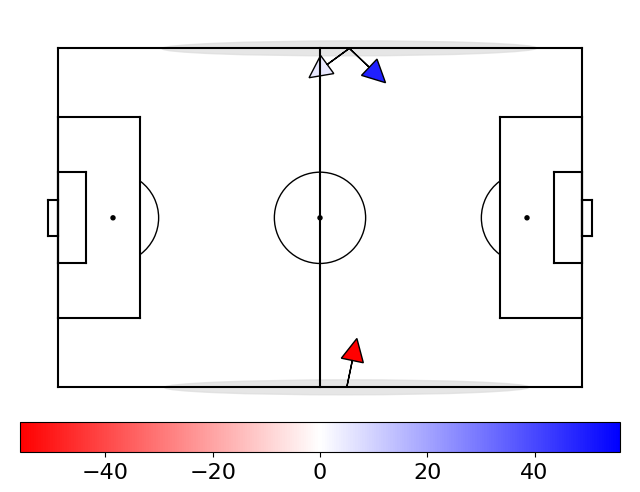

In [61]:
# difference = vec_p1 - vec_p2
# 파란색 = vec_p1에서 더 강조하는 전술 행동
vis.show_component_differences(loc_models, dir_models, vectors_pd.loc[1886], vectors_pd.loc[1889], 'Vissel Kobe', 'Sanfrecce Hiroshima', save=False)

# 상대가 달라질때마다 팀의 전술이 얼마나 달라지는지 계산

In [62]:

vectors = {}
set_teams = set(merged_weights.team_id.astype('int'))

for p in tqdm.tqdm(list(merged_weights.team_id.unique())):
    other_teams = set_teams - {int(p)}
    for p2 in other_teams:
        remaining_teams = other_teams - {p2}

        A_B_games = games[((( (games.away_team_id == p) & (games.home_team_id == p2))
                          |( (games.away_team_id == p2) & (games.home_team_id == p)))
                          )].game_id.values

        B_other_games = games[((( (games.away_team_id == p2) & (games.home_team_id.isin(remaining_teams)) )
                              | ((games.away_team_id.isin(remaining_teams)) & (games.home_team_id == p2)))
                              )].game_id.values


        vec1 = merged_weights.loc[((merged_weights.game_id.isin(A_B_games))
                                  & (merged_weights.team_id == p2)), dir_weights.columns].sum().values
        vec1 /= 2


        vec2 = merged_weights.loc[((merged_weights.game_id.isin(B_other_games))
                                  & (merged_weights.team_id == p2)), dir_weights.columns].sum().values
        vec2 /= 38

        vectors[f'{int(p)}_{int(p2)}_0'] = vec1 #vector of team 2 when playing only against team 1
        vectors[f'{int(p)}_{int(p2)}_1'] = vec2 #vector of team 2 when playing against all other teams except team 1

100%|██████████| 20/20 [01:30<00:00,  4.54s/it]


In [63]:
vectors_pd = pd.concat({k: pd.DataFrame(v).T for k,v in vectors.items()}).droplevel(level=1)
vectors_pd.index.name = "team_game"
vectors_pd.columns = dir_weights.columns

In [64]:
def show_vectors(team_id, set_teams, teams, vectors_pd):
    other_teams = set_teams - {int(team_id)}
    for p2 in other_teams:
        print(teams[teams.team_id == team_id].team_name.values[0] + "-" + teams[teams.team_id == p2].team_name.values[0])
        sli = vectors_pd.loc[vectors_pd.index.str.contains(f'^{int(team_id)}_{int(p2)}_')]
        plt.figure(figsize=(50,10))
        plt.plot(vectors_pd.columns.values, sli.iloc[0,:].values, 'r')
        plt.plot(vectors_pd.columns.values, sli.iloc[1,:].values, 'b')
        plt.show()

def get_mean_difference_vector(team):
    differences = []
    for t in set_teams:
        if (t != team):
            differences.append(vectors_pd.loc[f"{team}_{int(t)}_0"] - vectors_pd.loc[f"{team}_{int(t)}_1"])
            # difference between how team t plays against 'team' and how team t play against all other teams

    mean_vector = np.mean(differences, 0)
    mean_pd = pd.DataFrame(columns=vectors_pd.columns.values)
    mean_pd.loc[0] = mean_vector
    mean_pd.loc[1] = np.zeros_like(mean_vector)

    return mean_pd

### Defensive style of Machida Zelvia
- 2024시즌 J리그 최소실점 팀

In [65]:
print(teams[teams.team_name == 'FC Machida Zelvia'].team_id)

3    4609
Name: team_id, dtype: int64


FC Machida Zelvia-Albirex Niigata


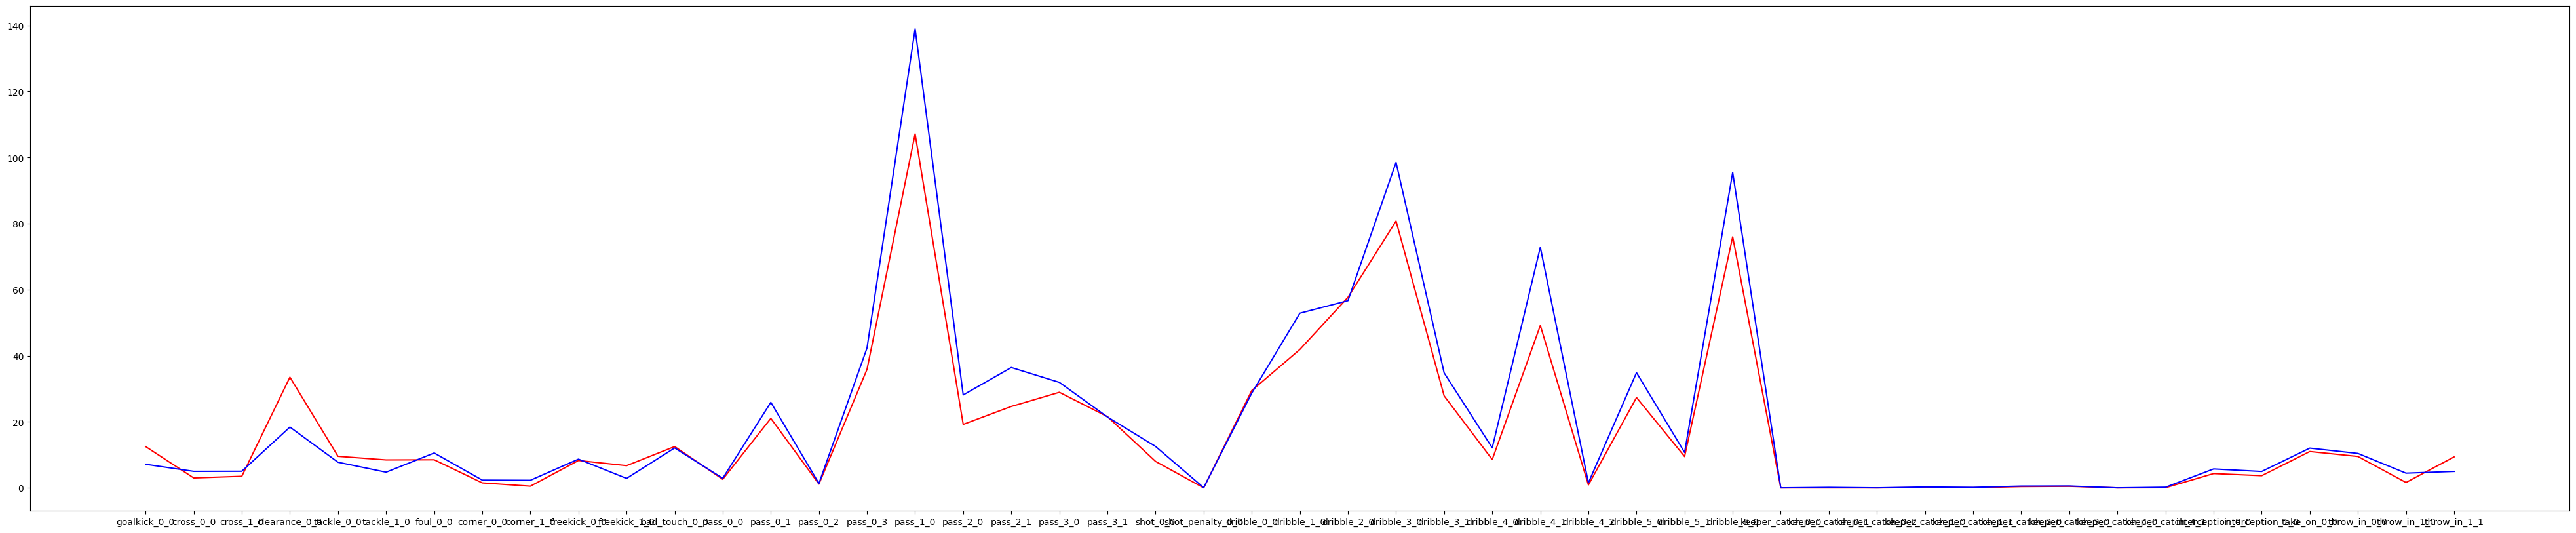

FC Machida Zelvia-Kyoto Sanga FC


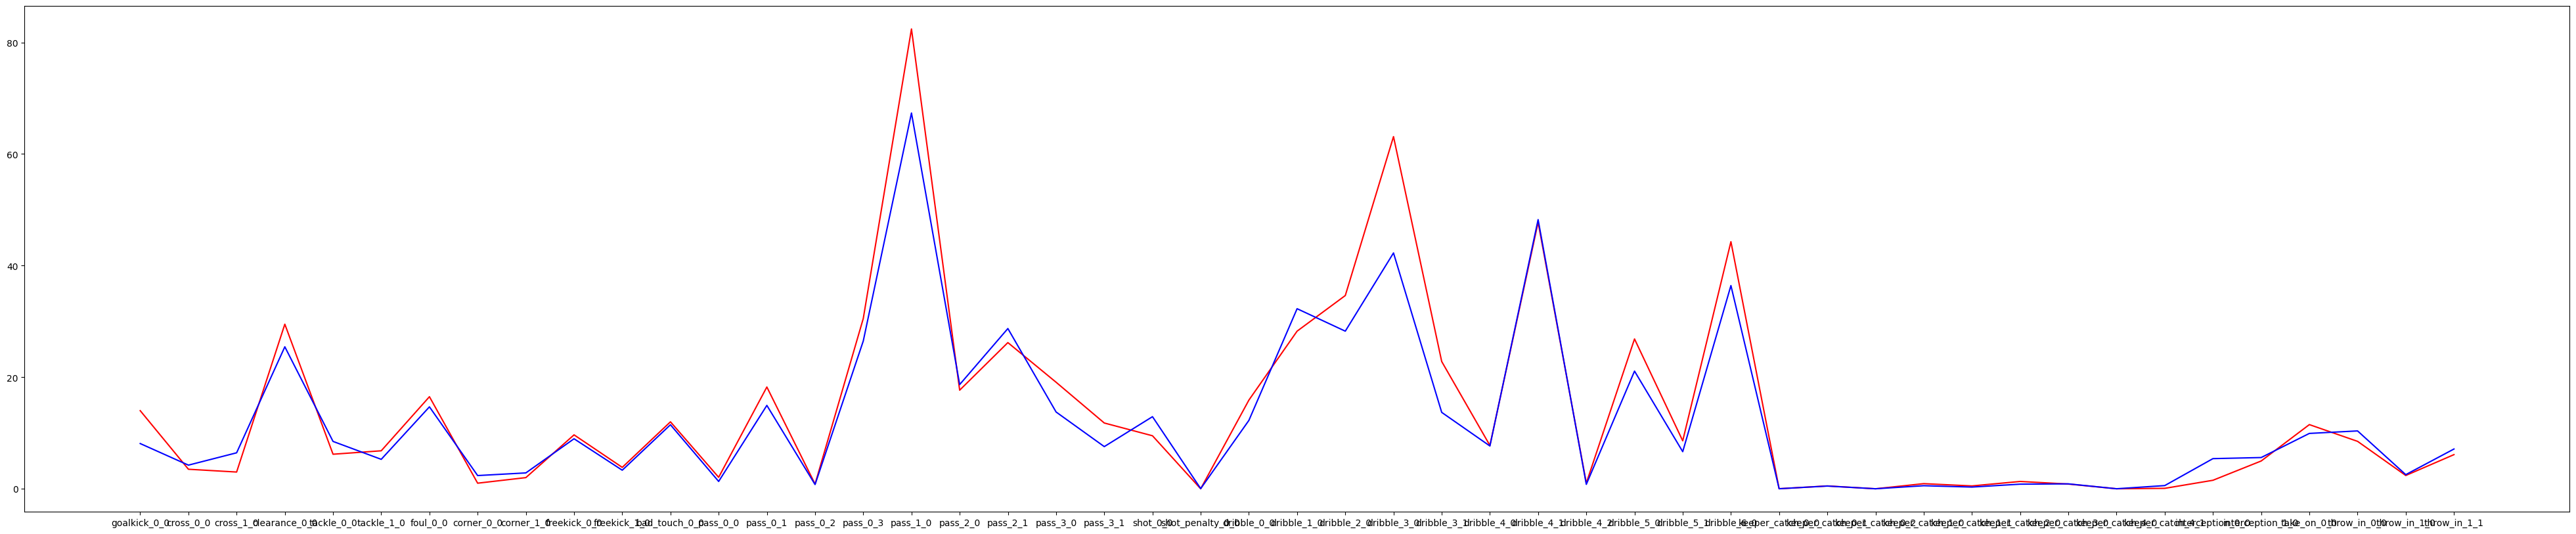

FC Machida Zelvia-Yokohama F. Marinos


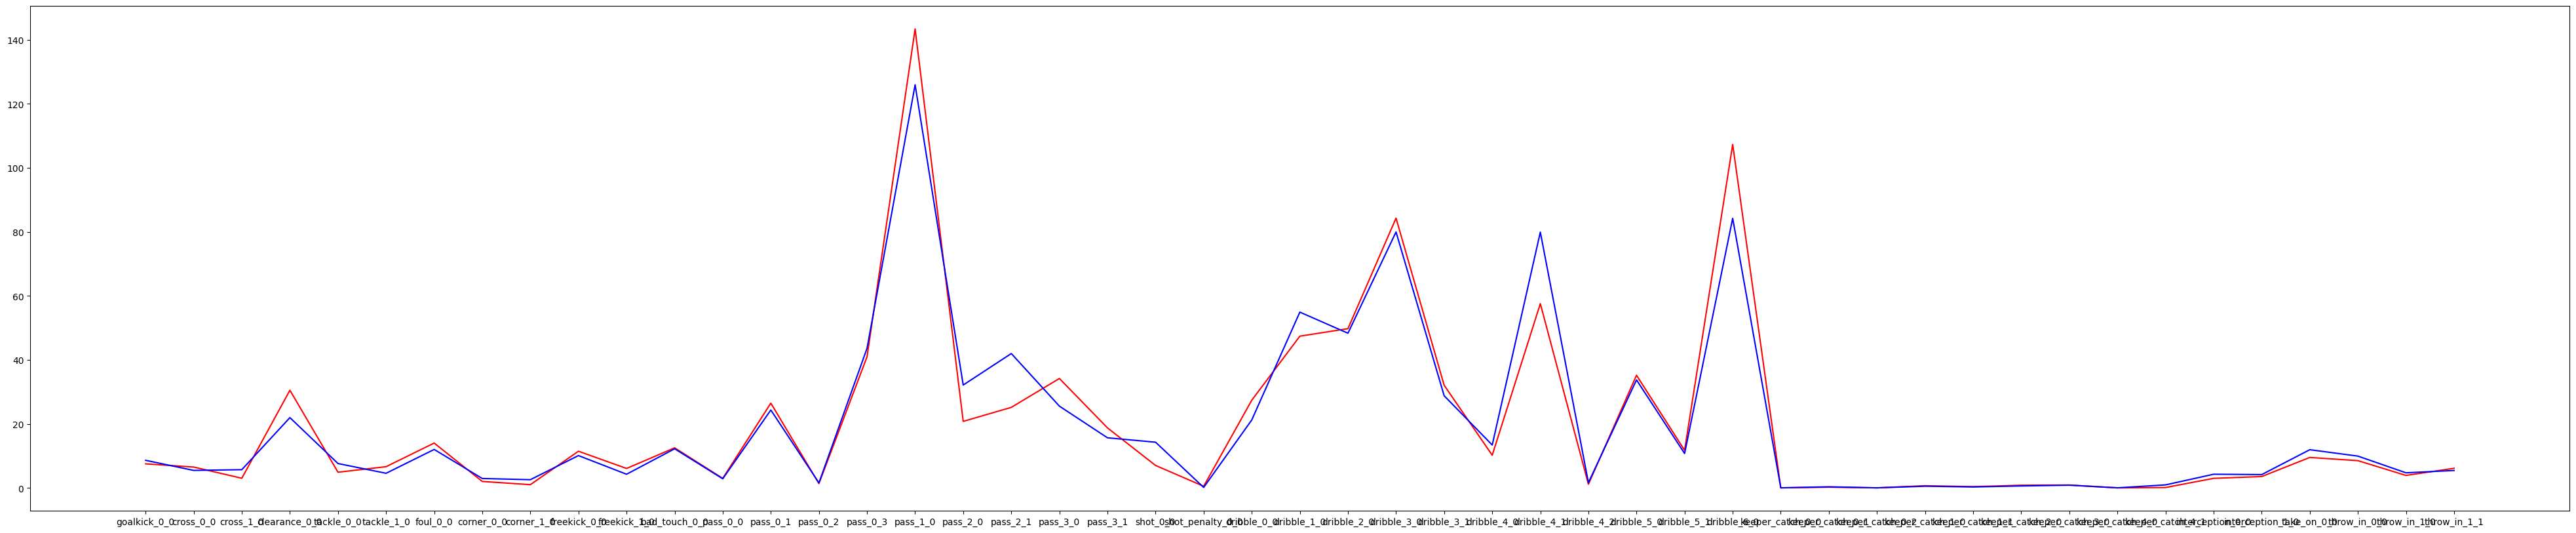

FC Machida Zelvia-Kashima Antlers


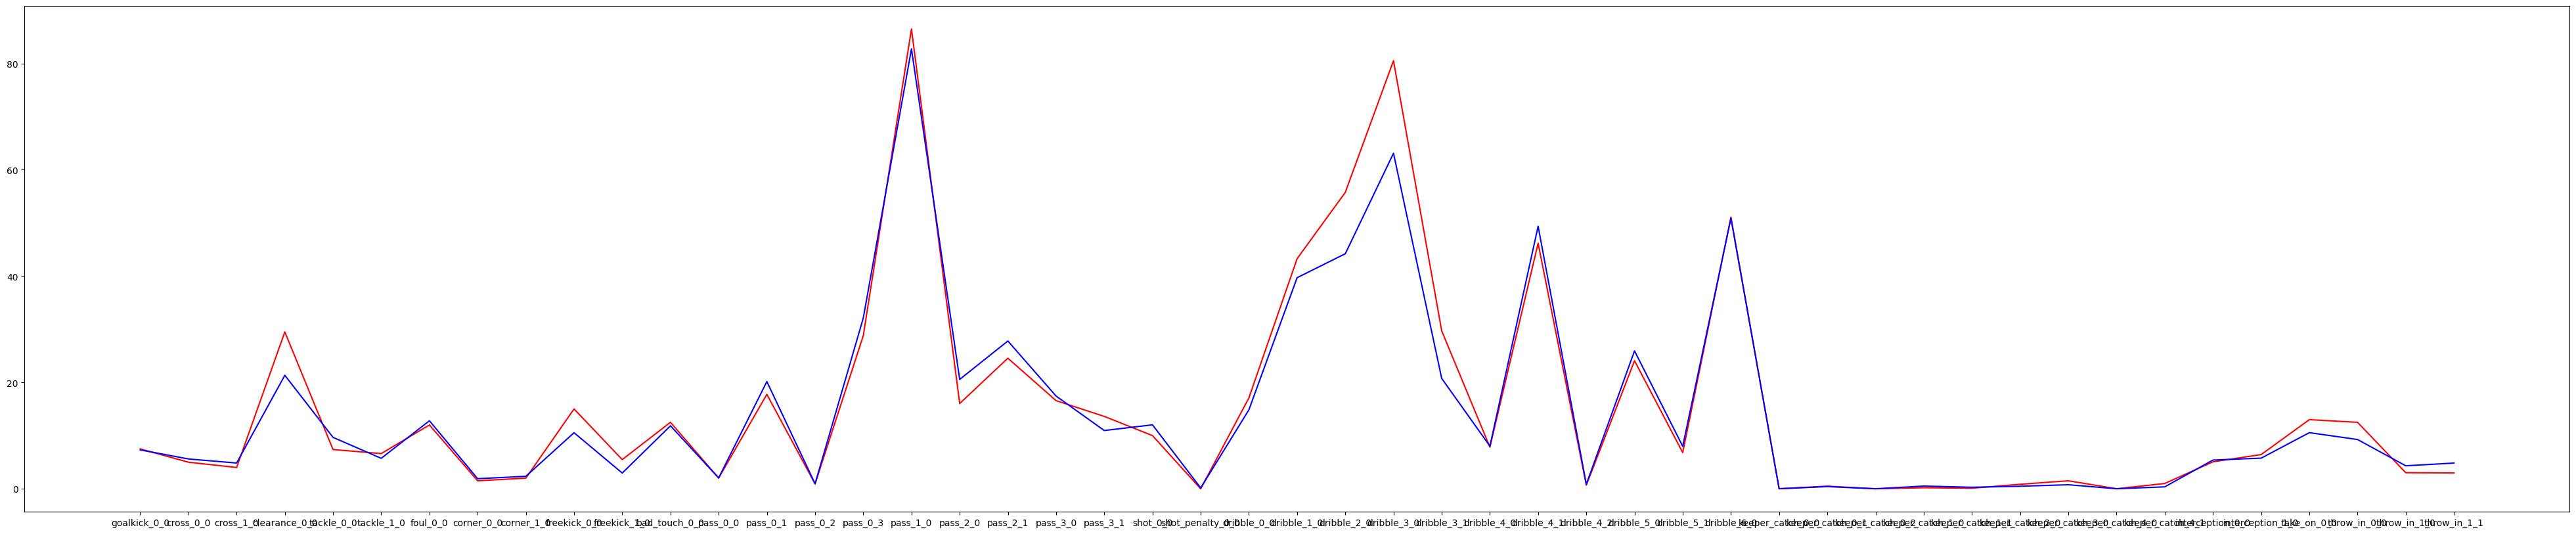

FC Machida Zelvia-Urawa Reds


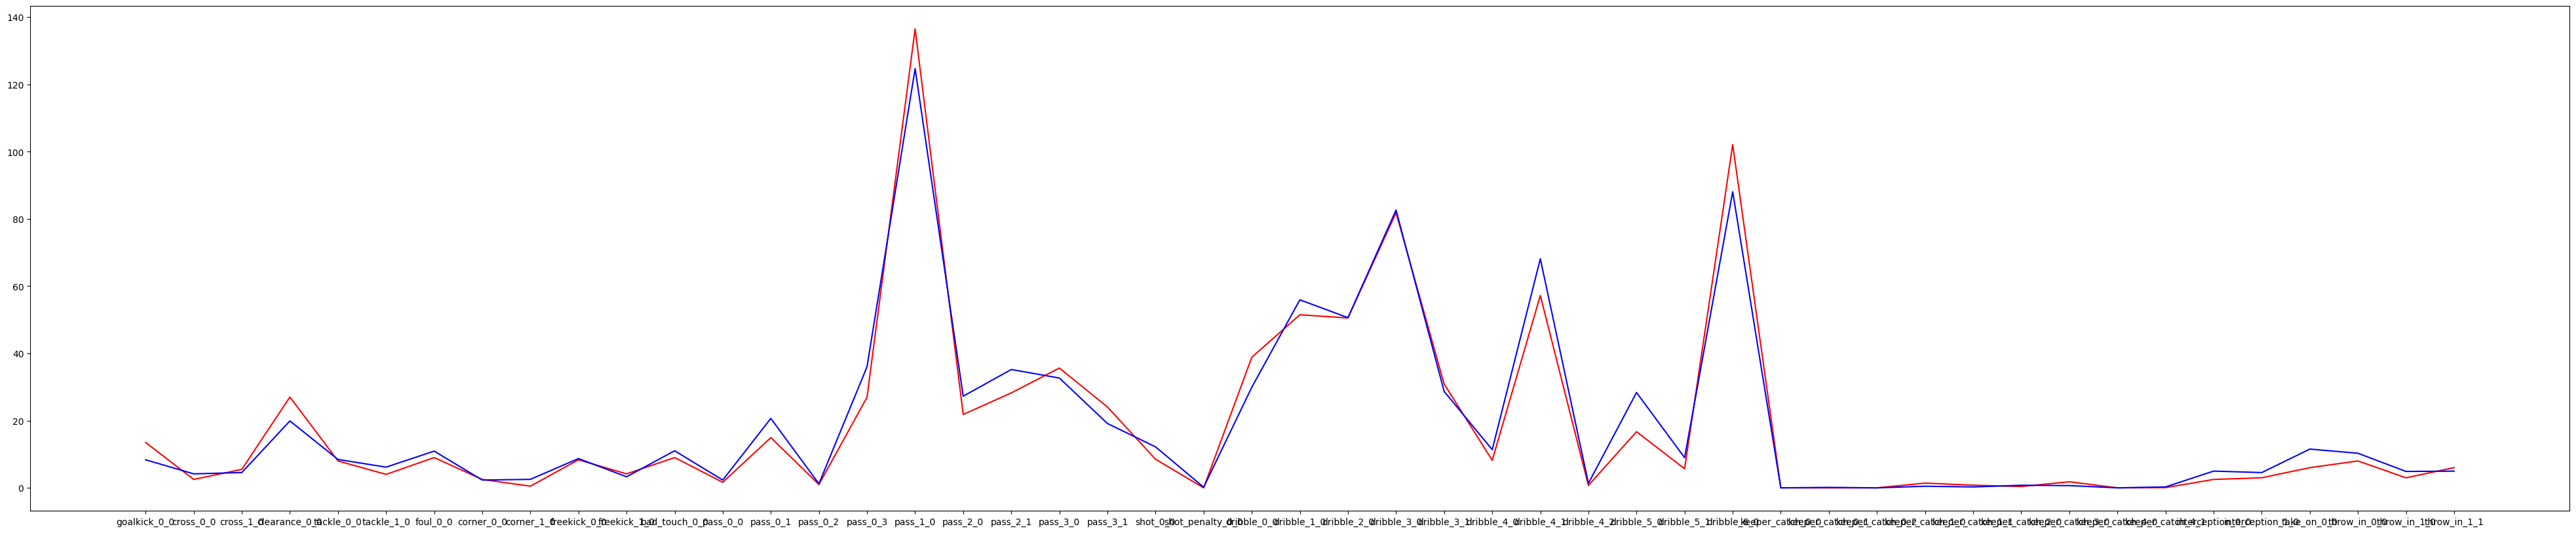

FC Machida Zelvia-Nagoya Grampus


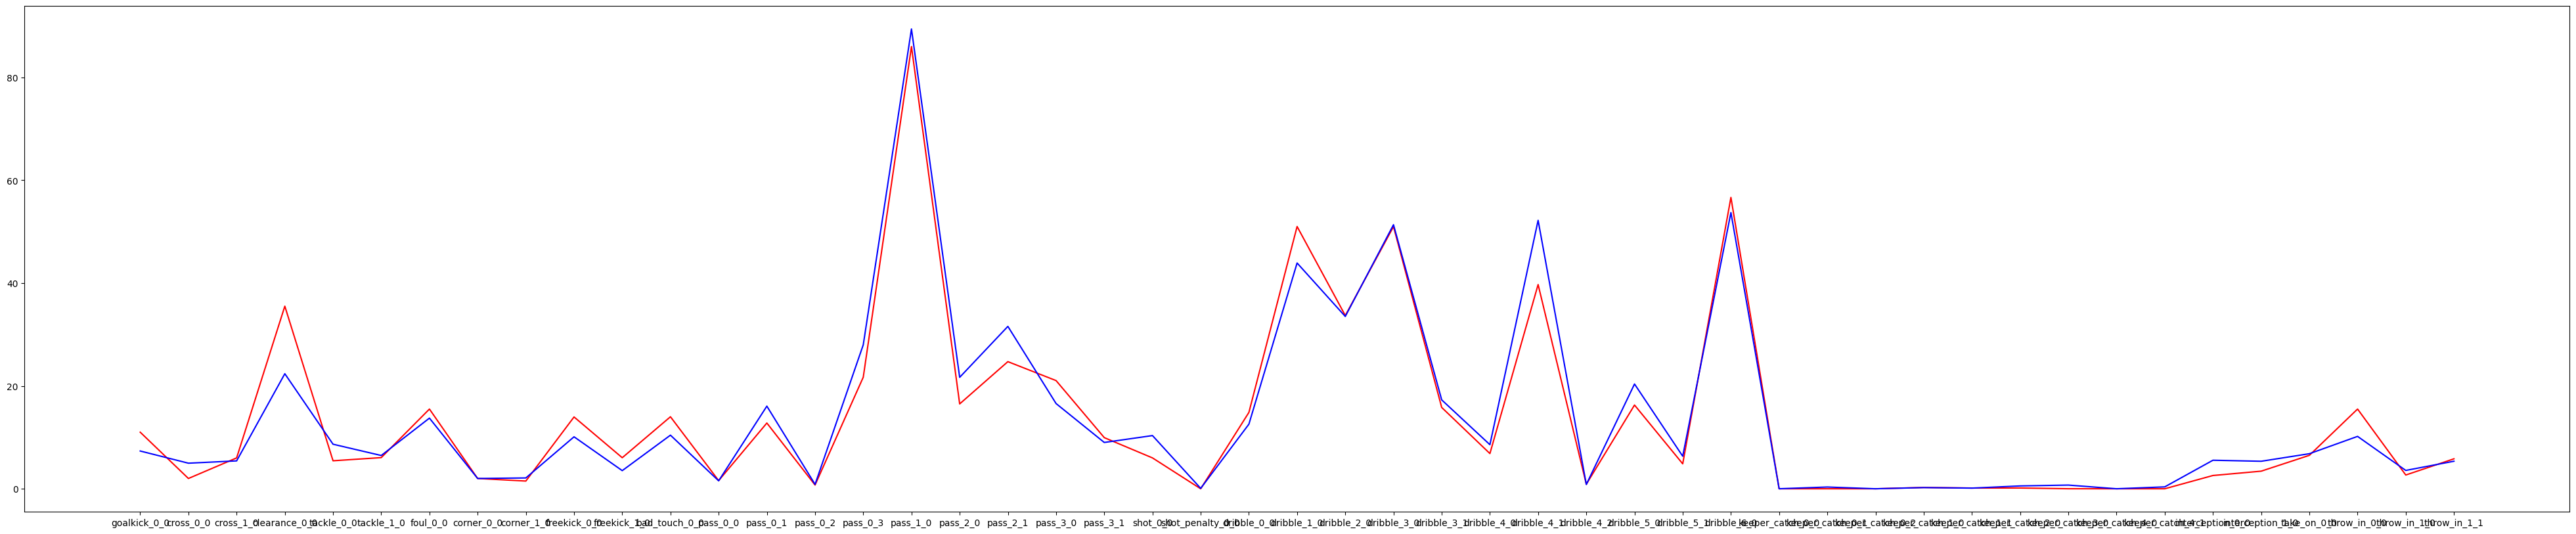

FC Machida Zelvia-Gamba Osaka


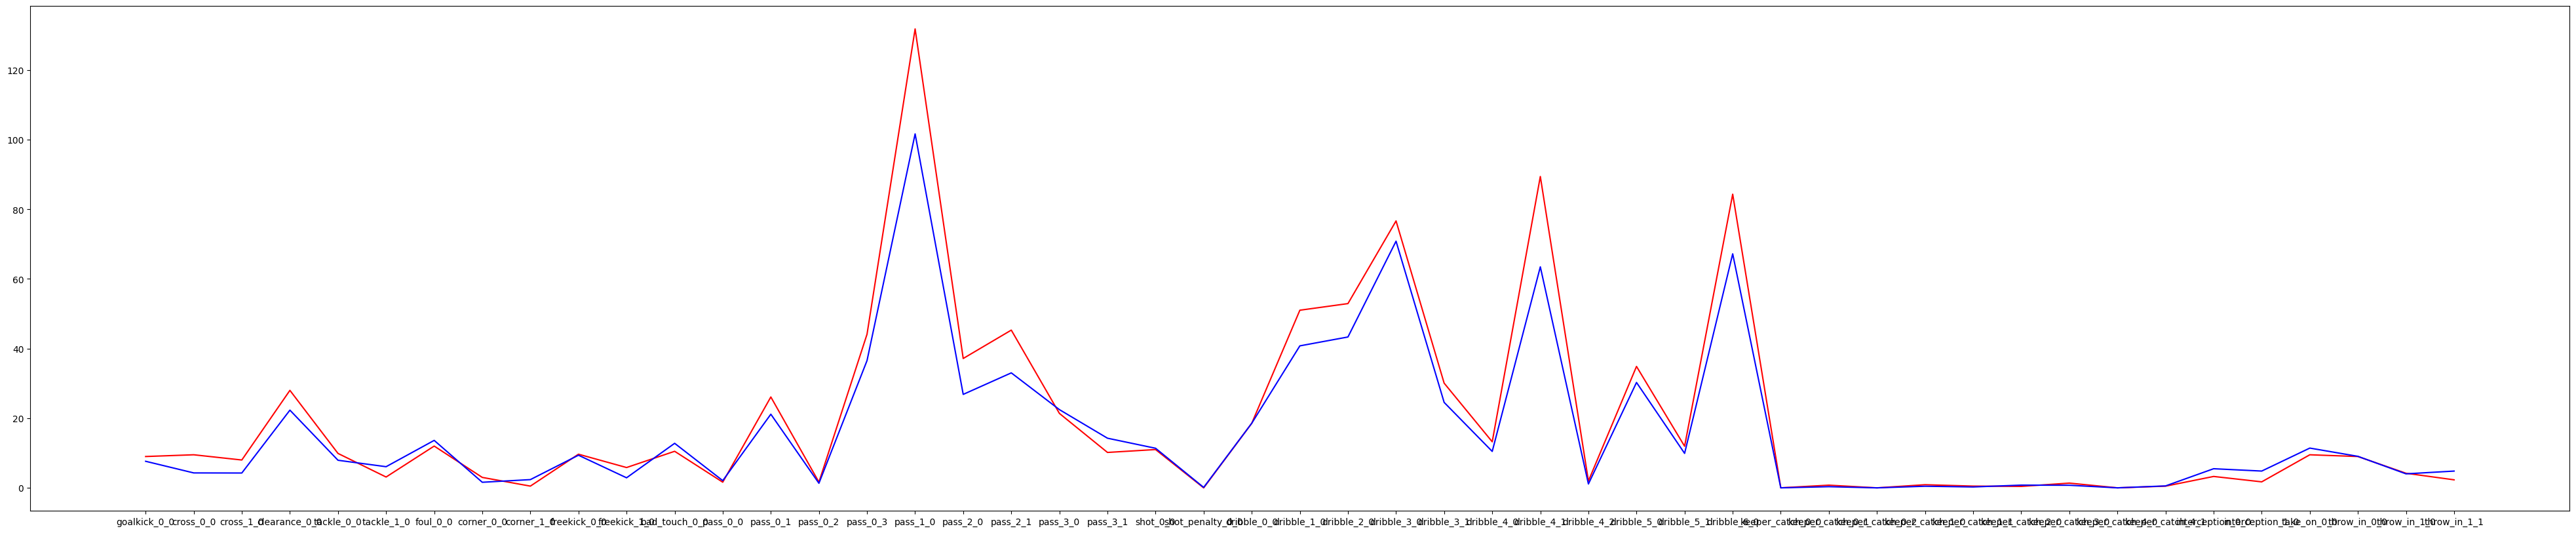

FC Machida Zelvia-Vissel Kobe


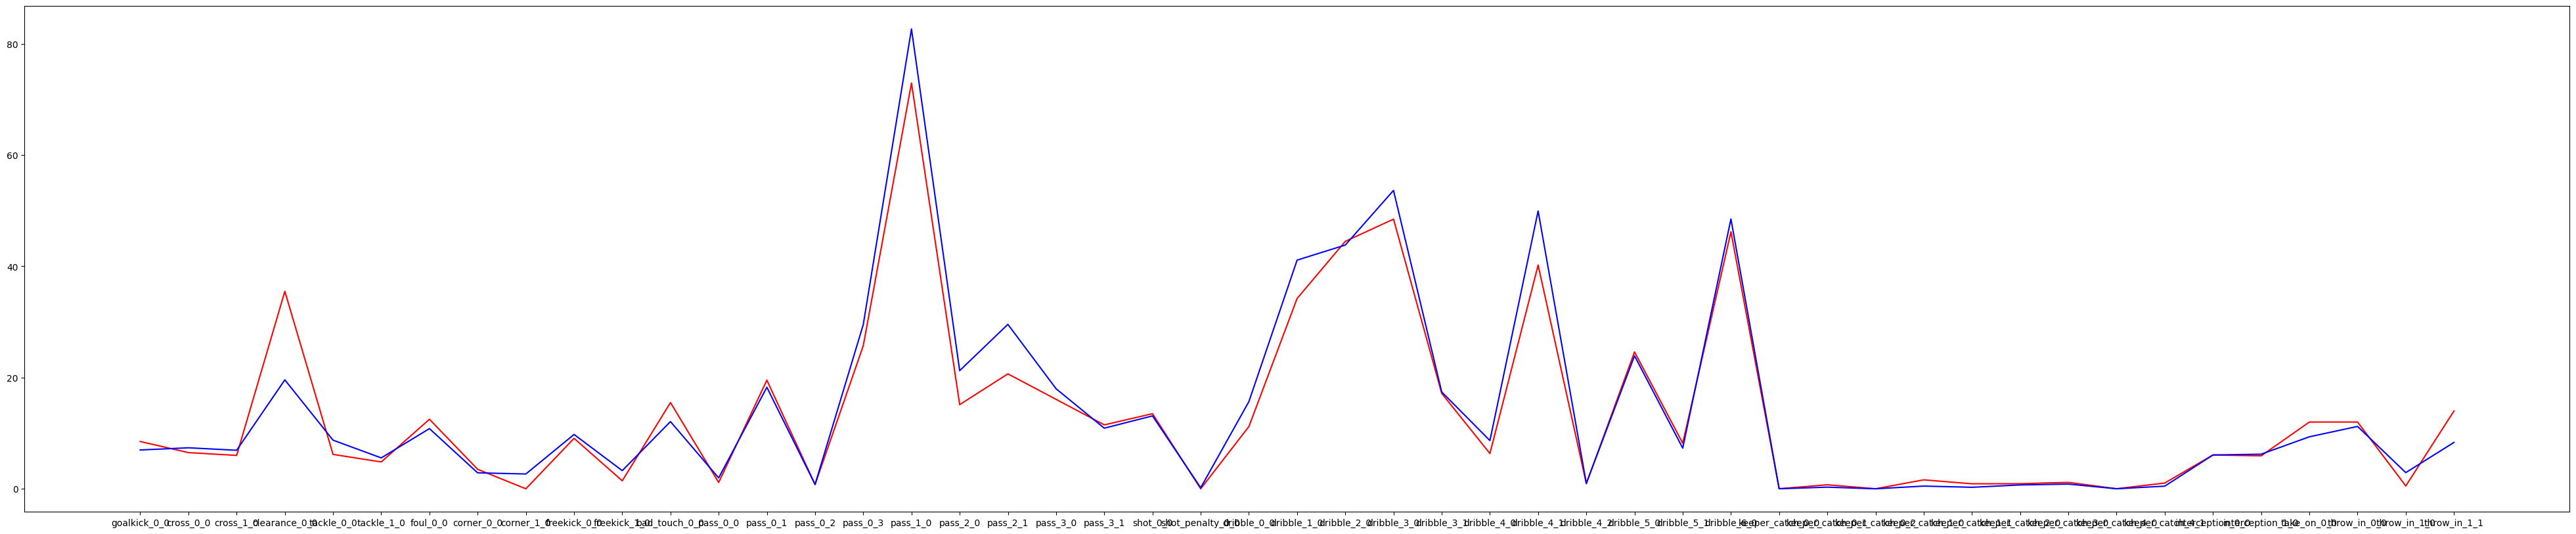

FC Machida Zelvia-Tokyo


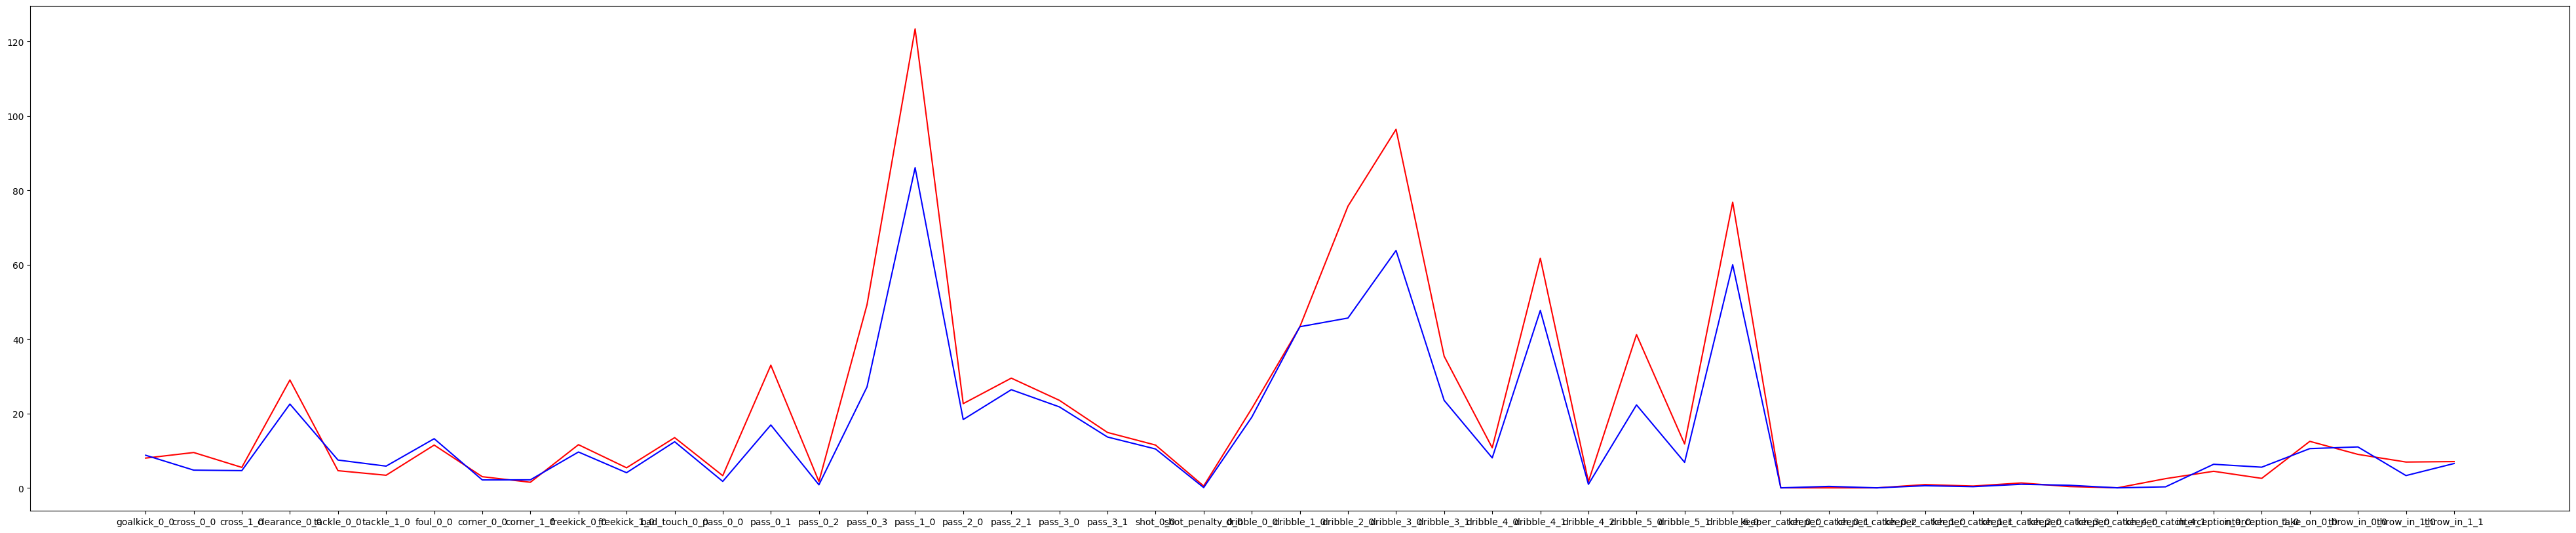

FC Machida Zelvia-Sanfrecce Hiroshima


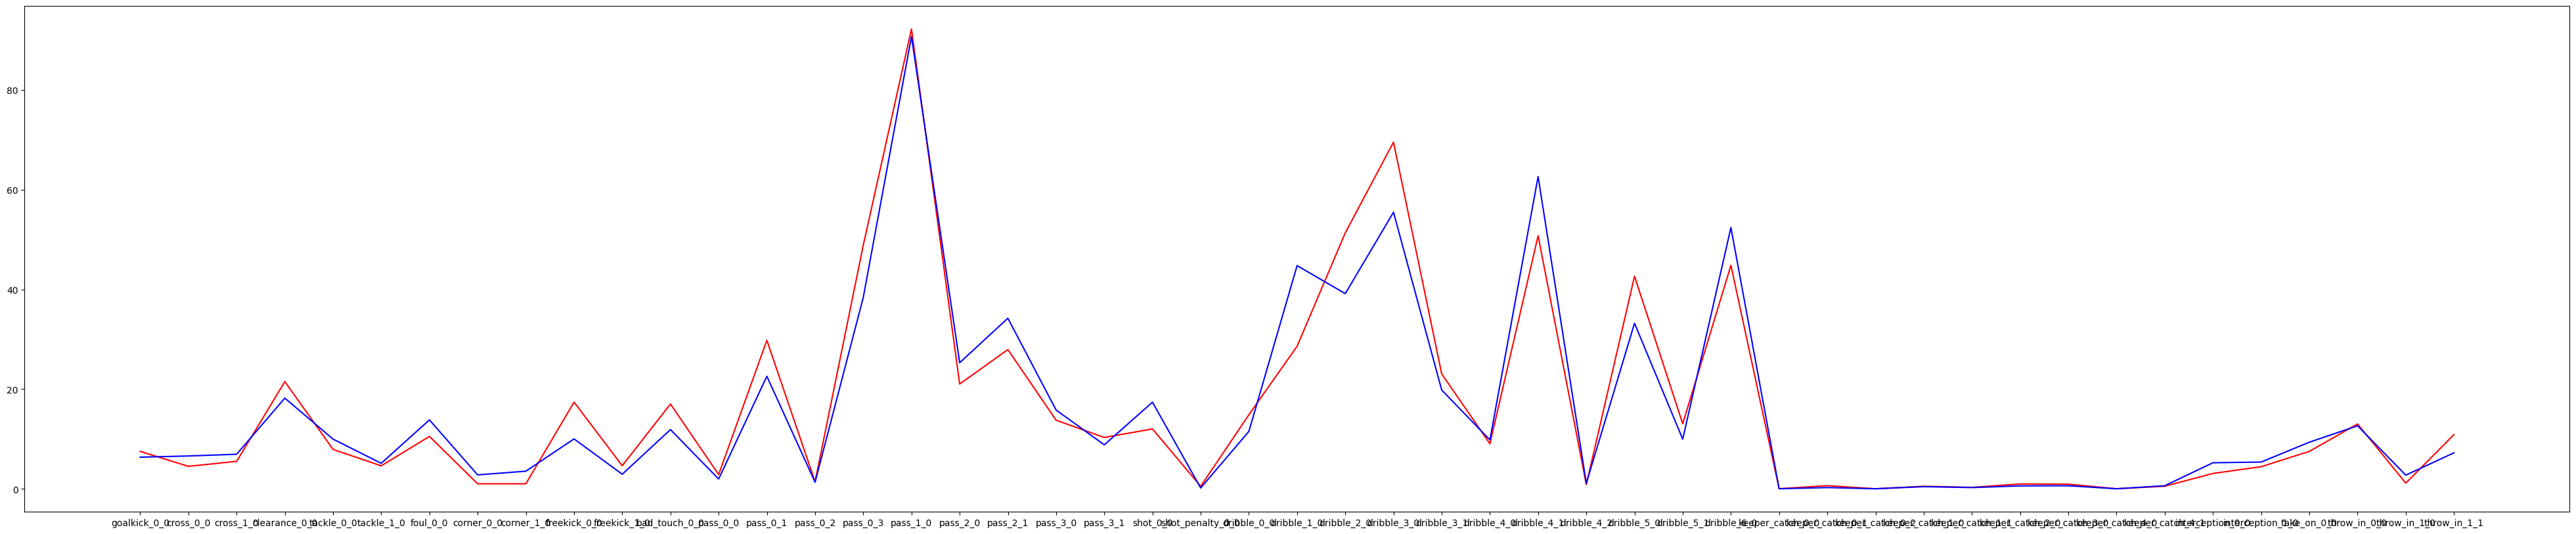

FC Machida Zelvia-Kashiwa Reysol


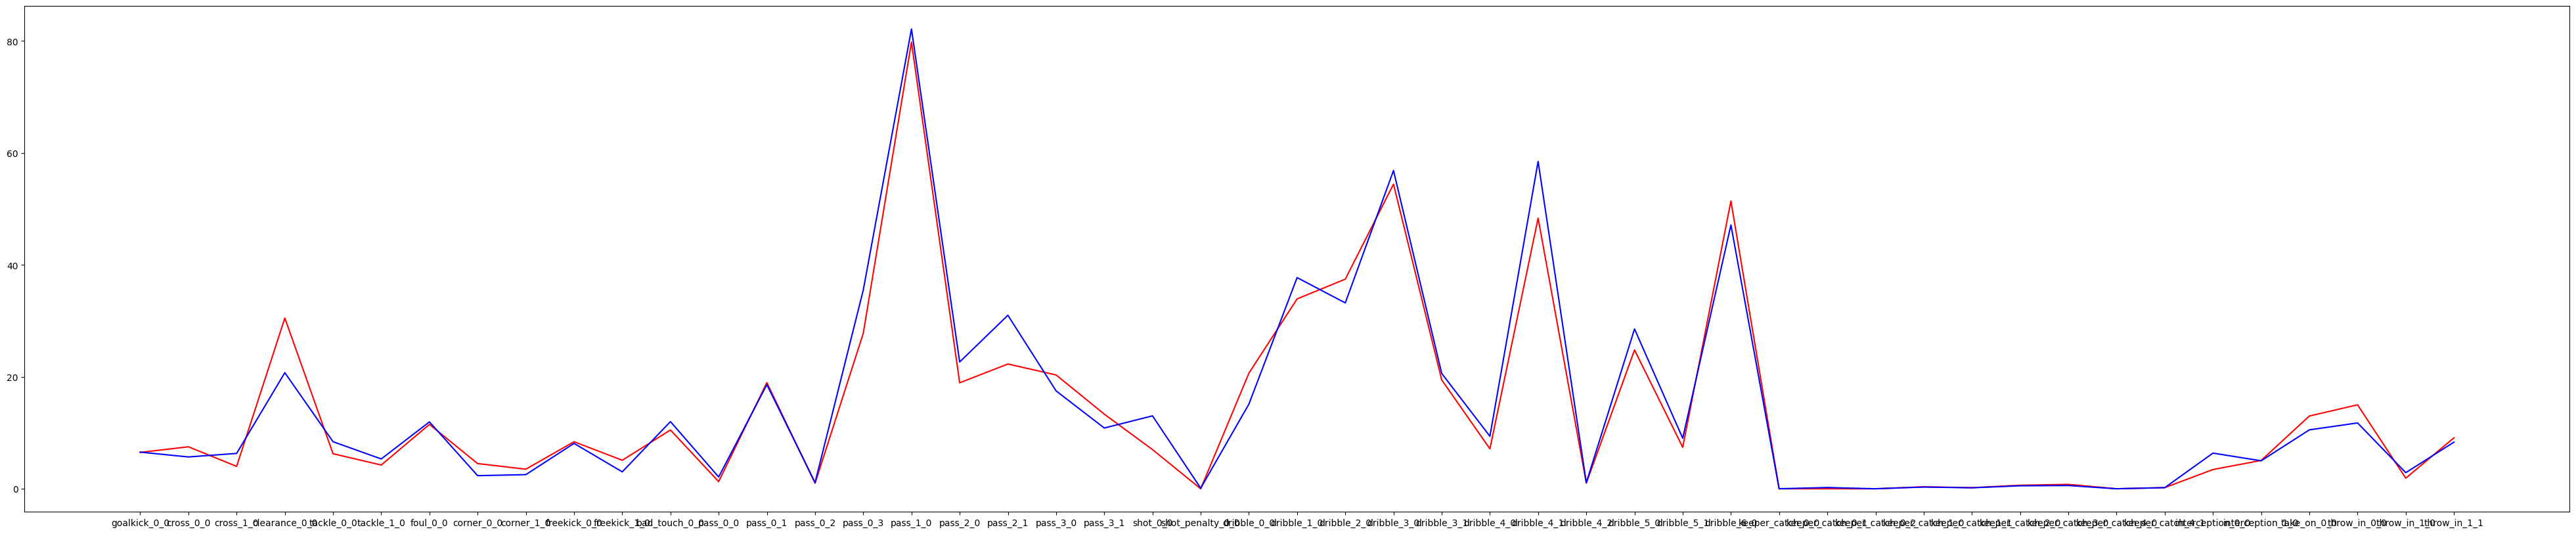

FC Machida Zelvia-Cerezo Osaka


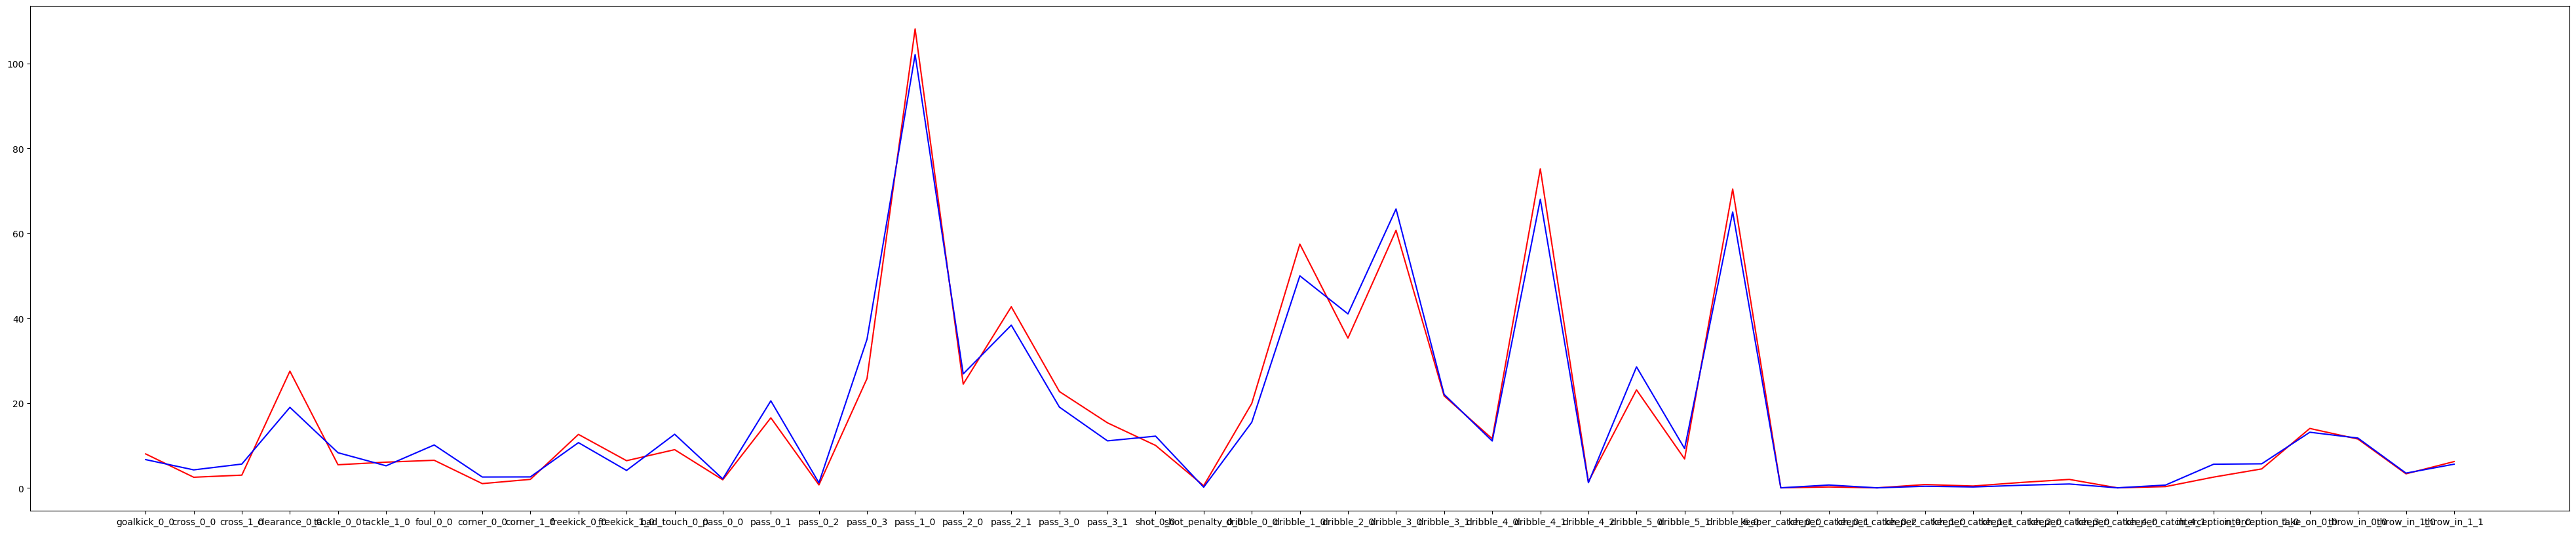

FC Machida Zelvia-Avispa Fukuoka


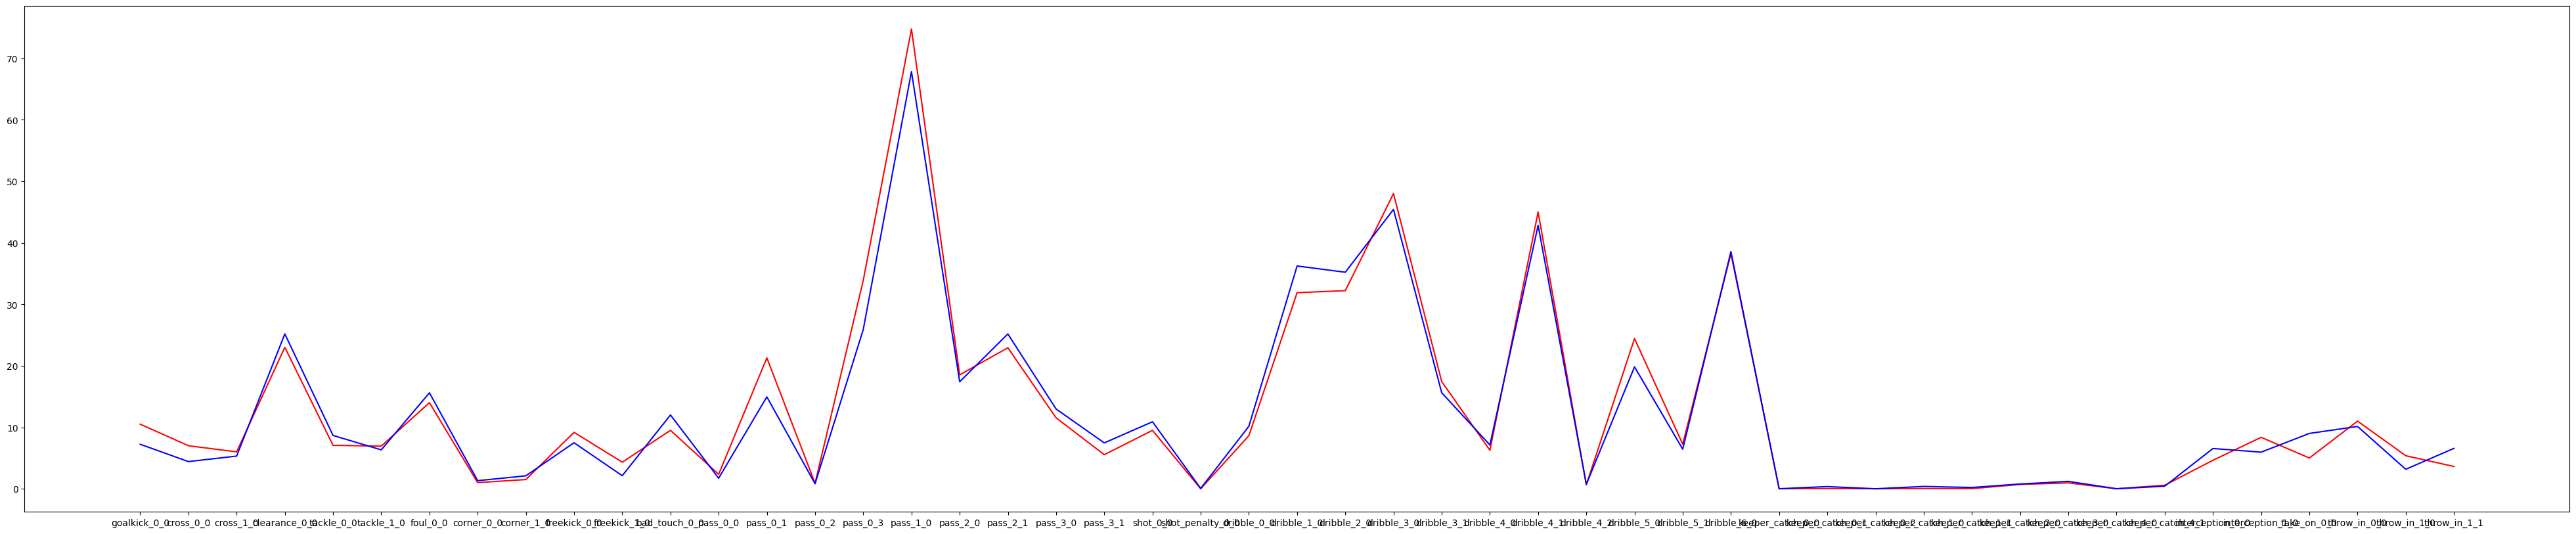

FC Machida Zelvia-Kawasaki Frontale


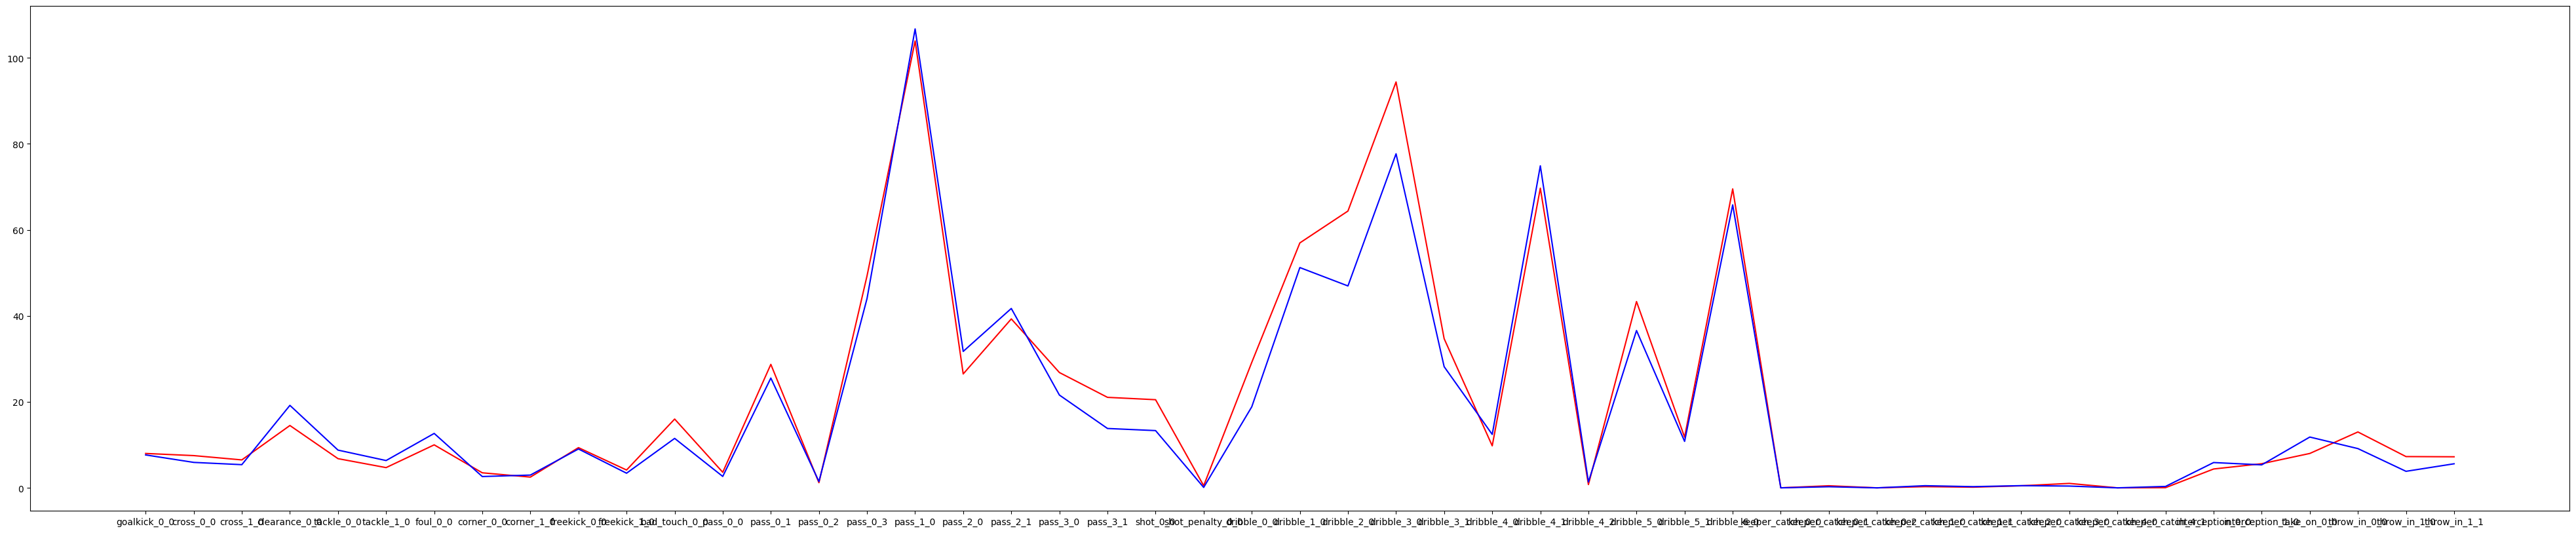

FC Machida Zelvia-Sagan Tosu


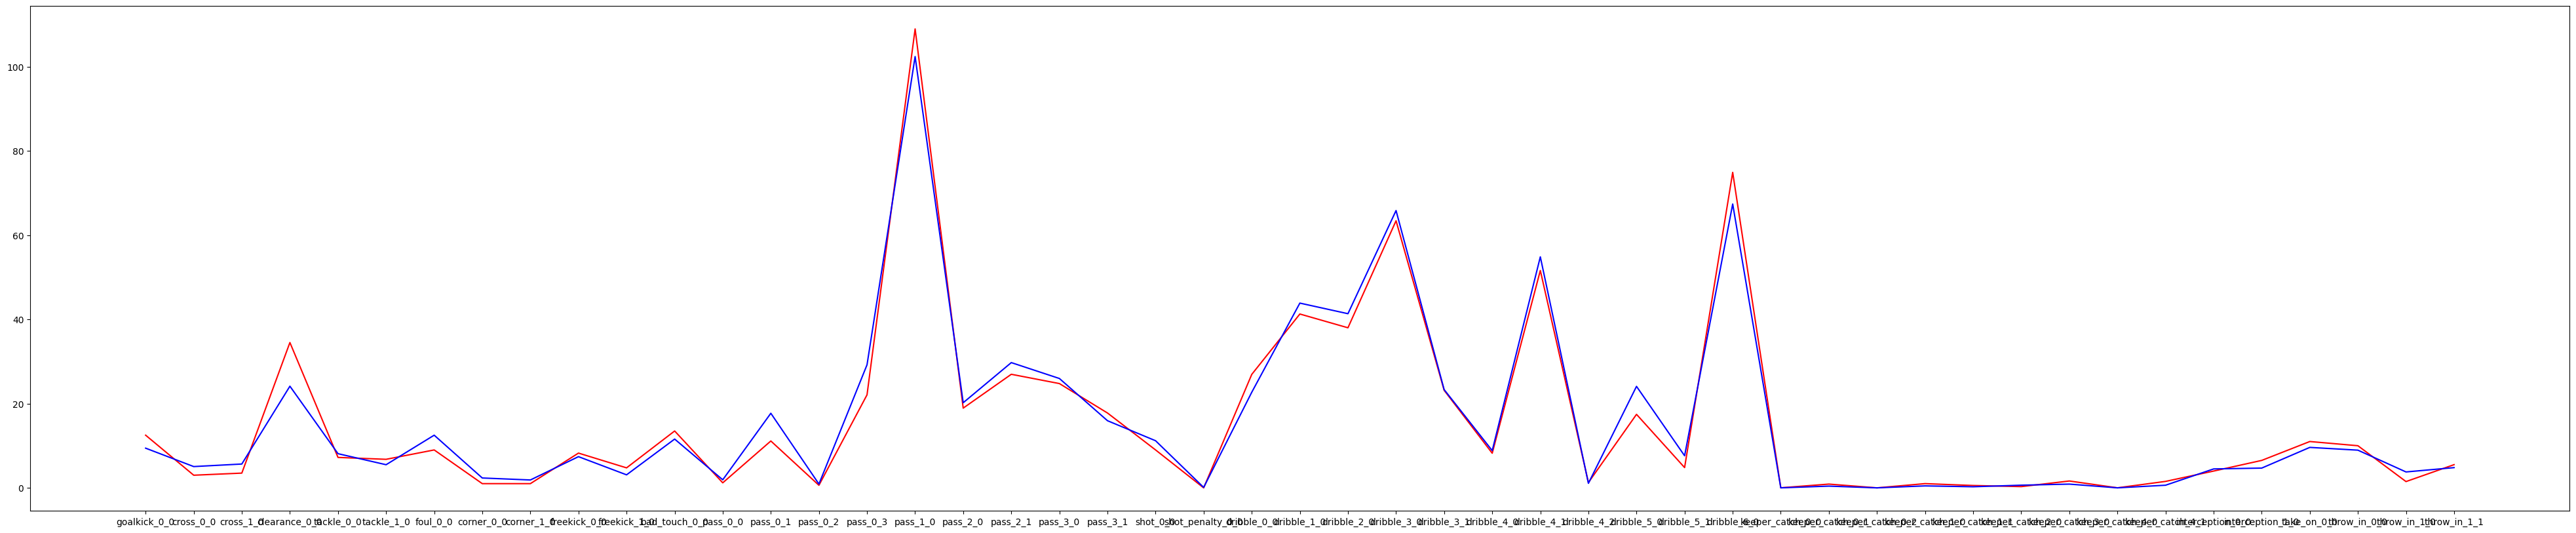

FC Machida Zelvia-Shonan Bellmare


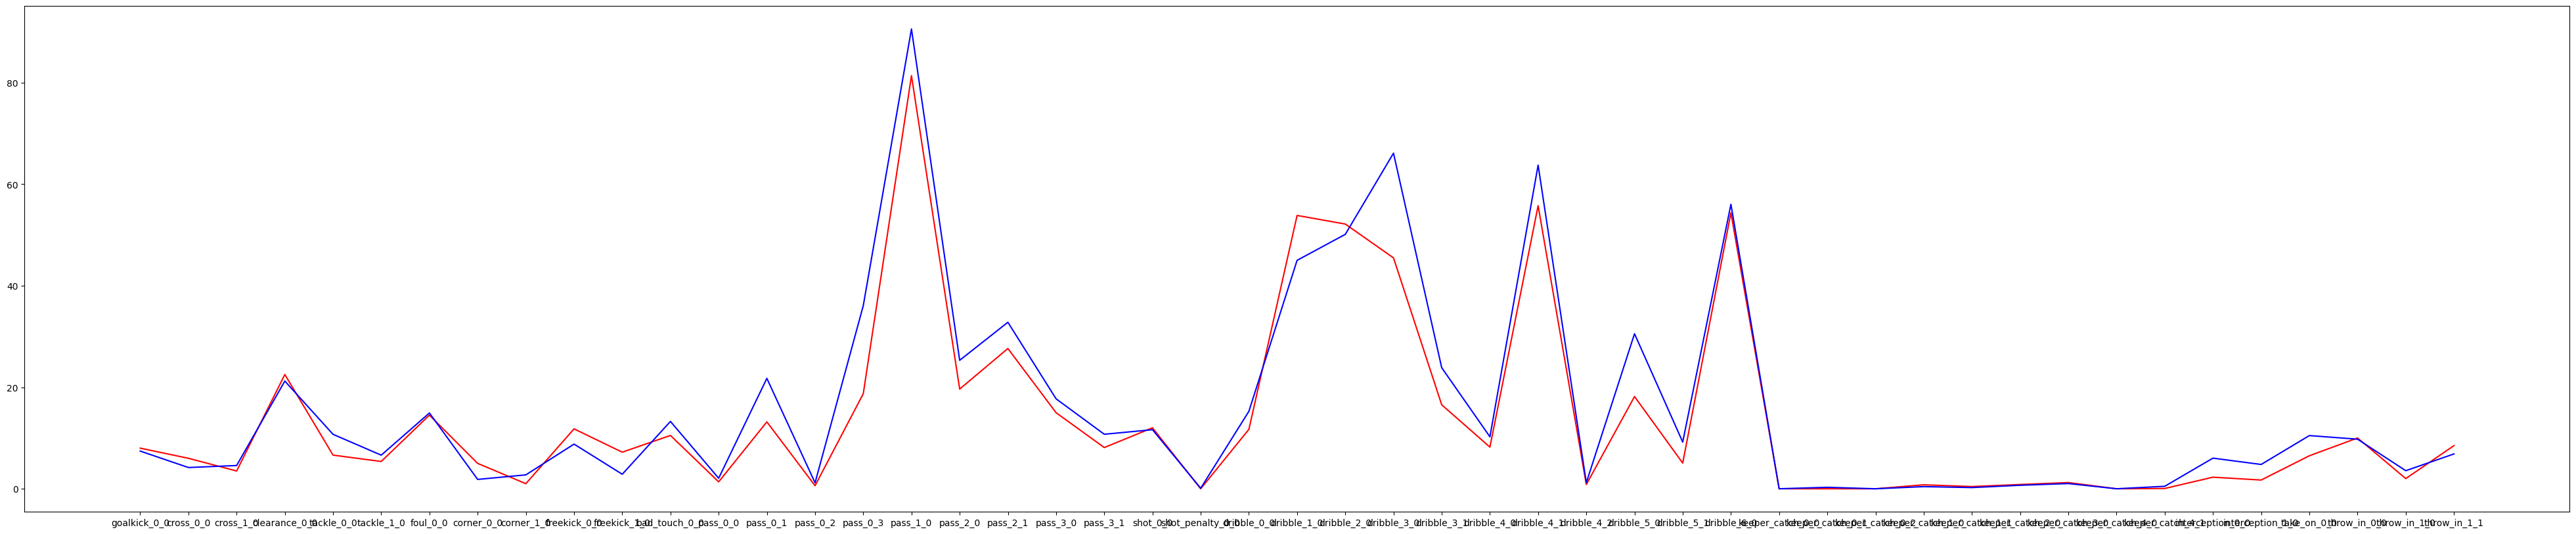

FC Machida Zelvia-Consadole Sapporo


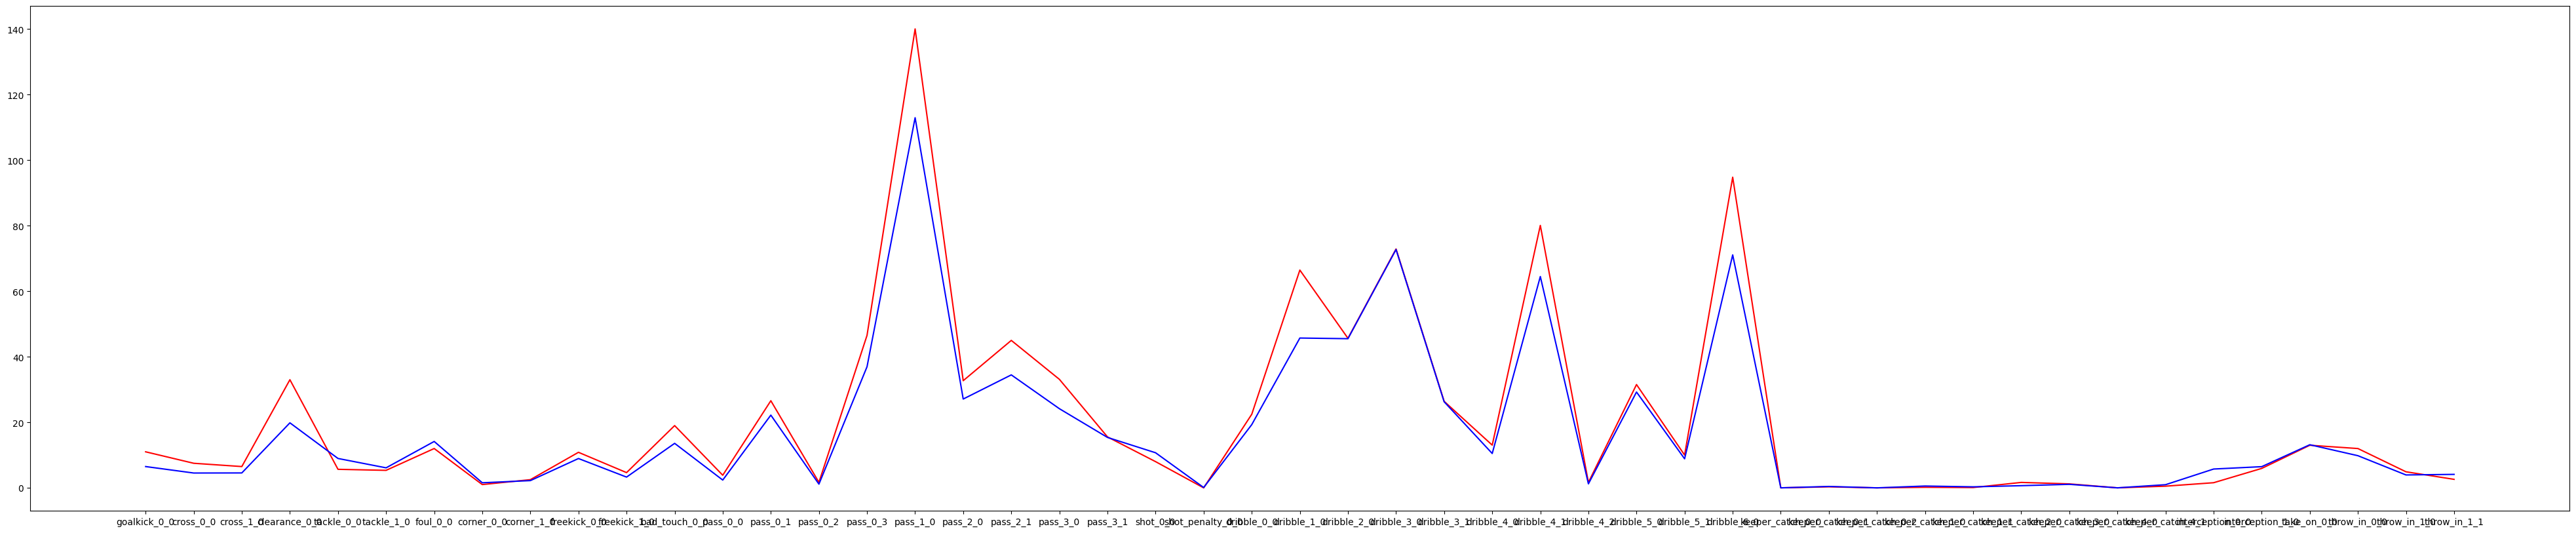

FC Machida Zelvia-Júbilo Iwata


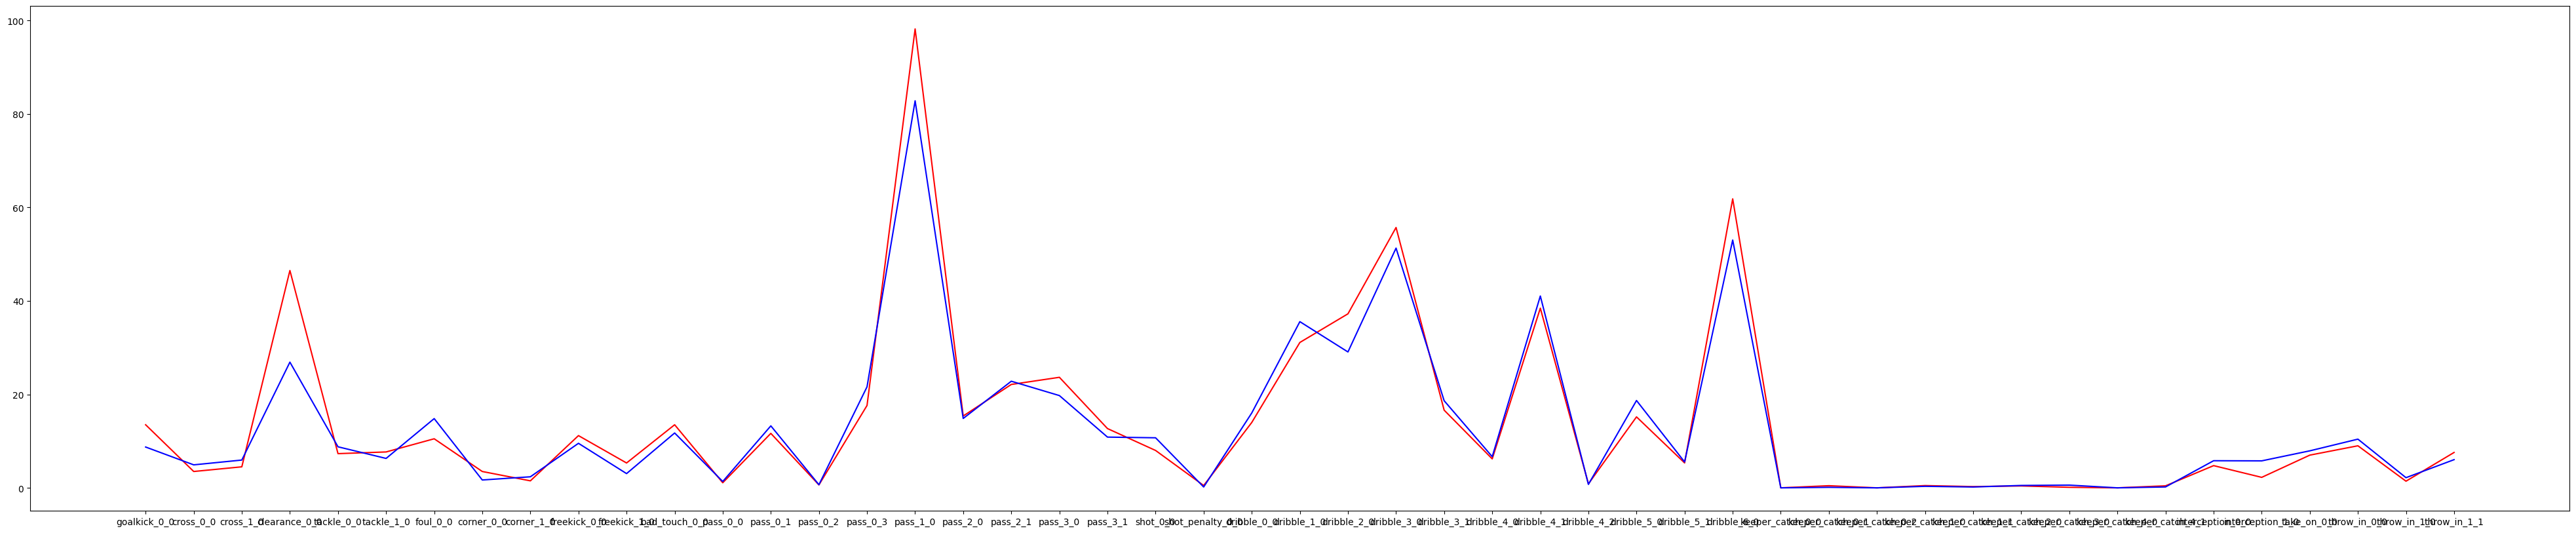

FC Machida Zelvia-Tokyo Verdy


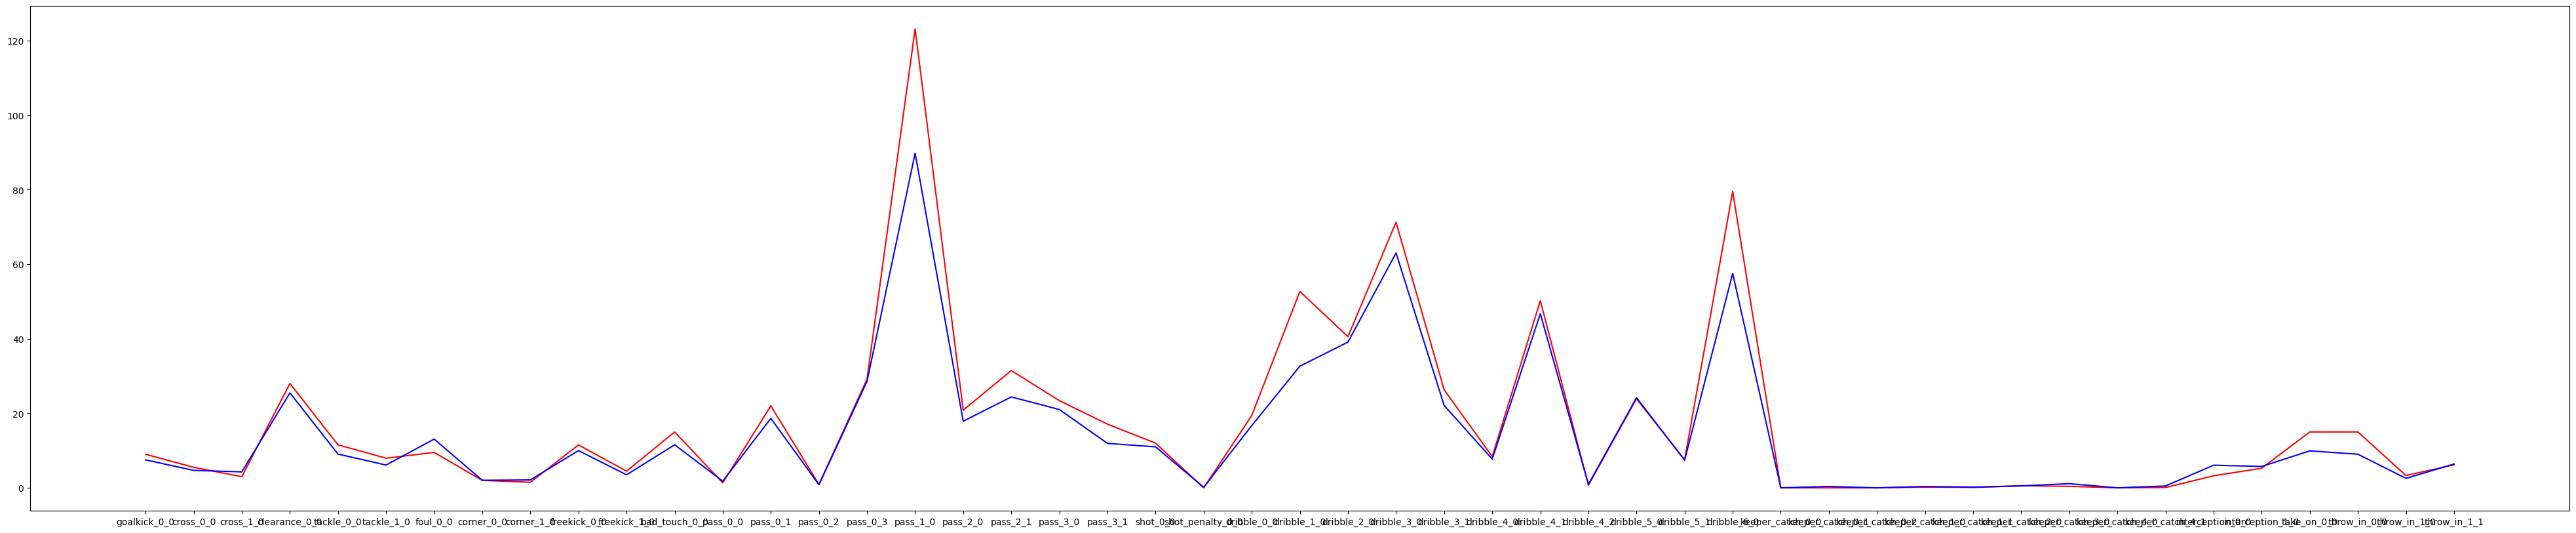

In [66]:
show_vectors(4609, set_teams, teams, vectors_pd)

In [67]:
mean_pd_machida = get_mean_difference_vector(4609)

goalkick 1


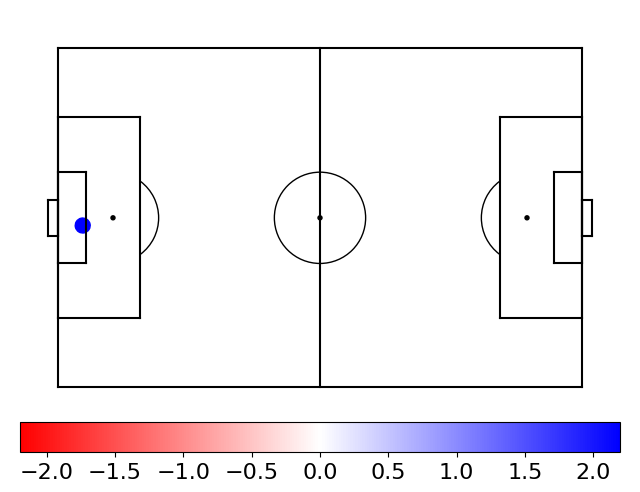

cross 2


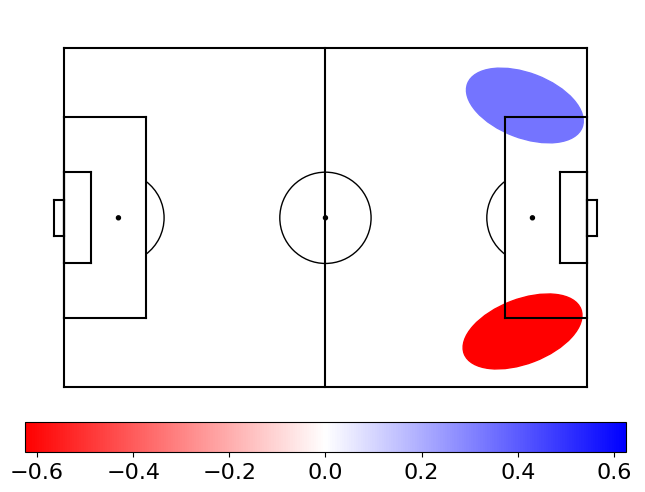

clearance 1


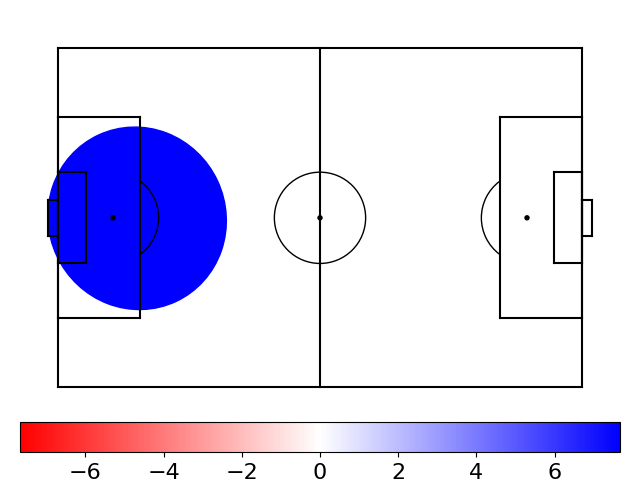

tackle 2


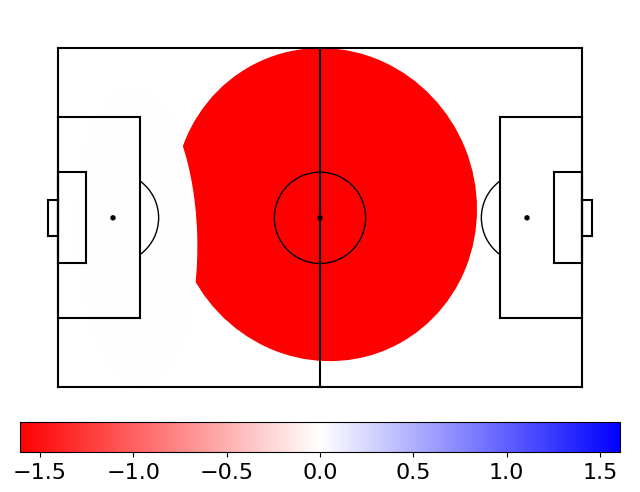

foul 1


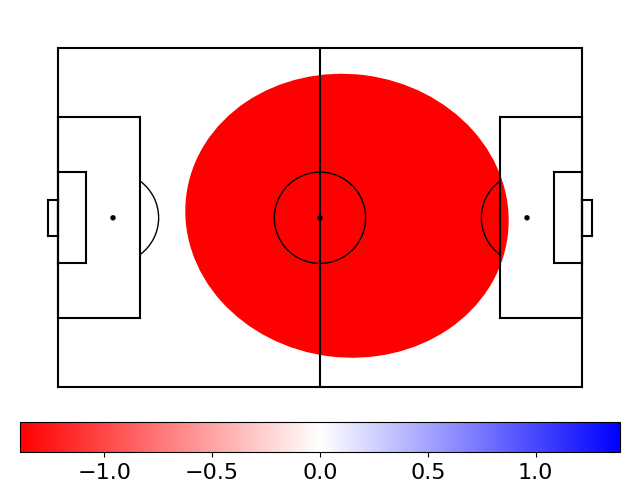

corner 2


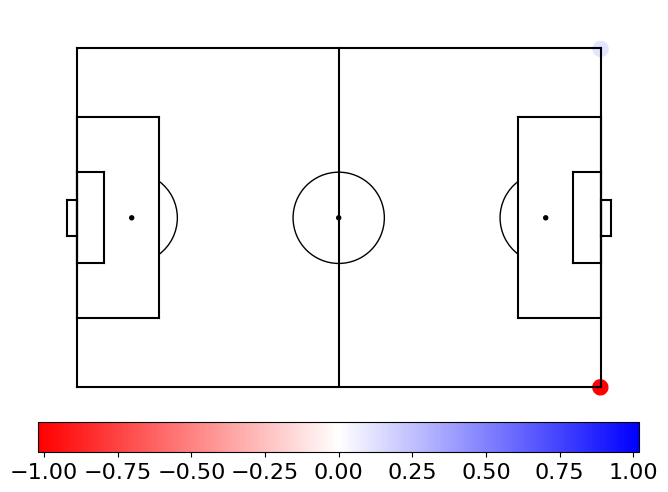

freekick 2


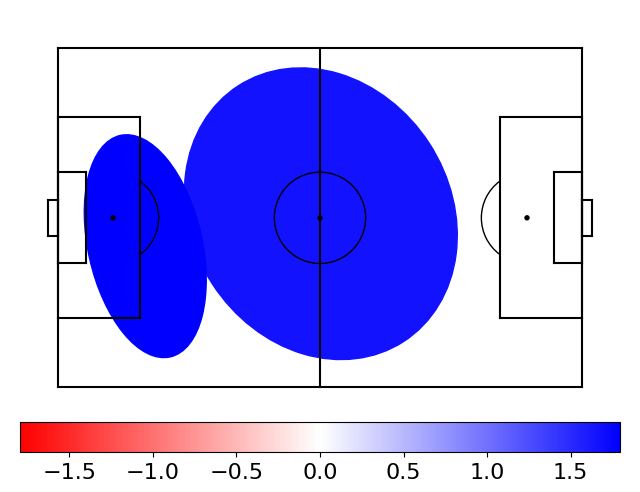

bad_touch 1


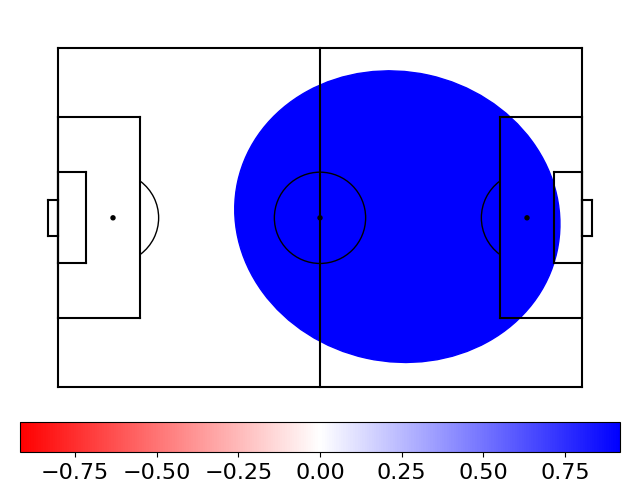

pass 7
pass_0 4
pass_1 1
pass_2 2
pass_3 2


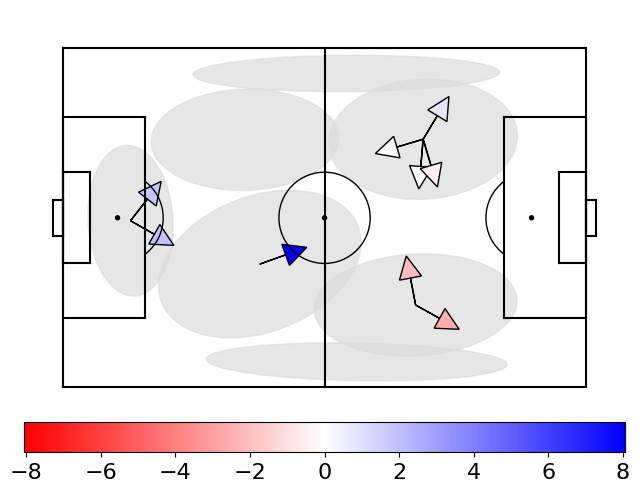

shot 1


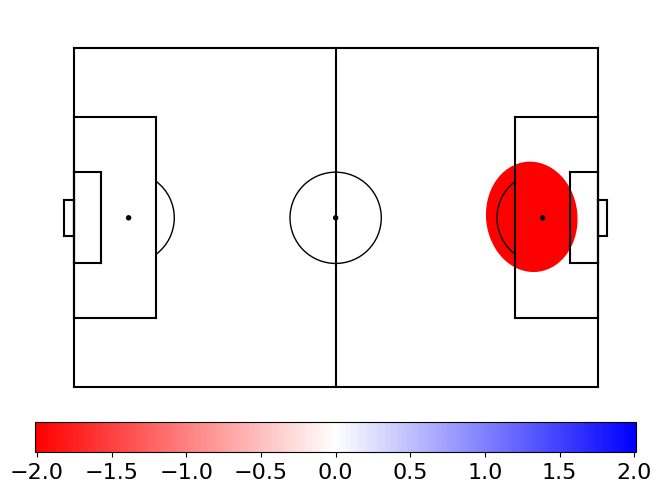

shot_penalty 1


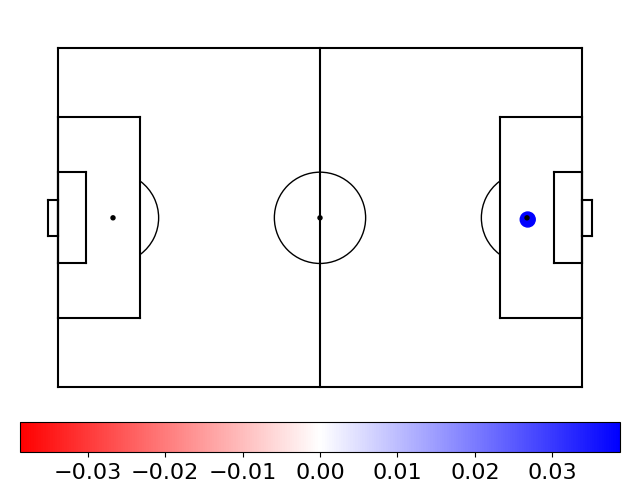

dribble 7
dribble_0 1
dribble_1 1
dribble_2 1
dribble_3 2
dribble_4 3
dribble_5 2
dribble_6 1


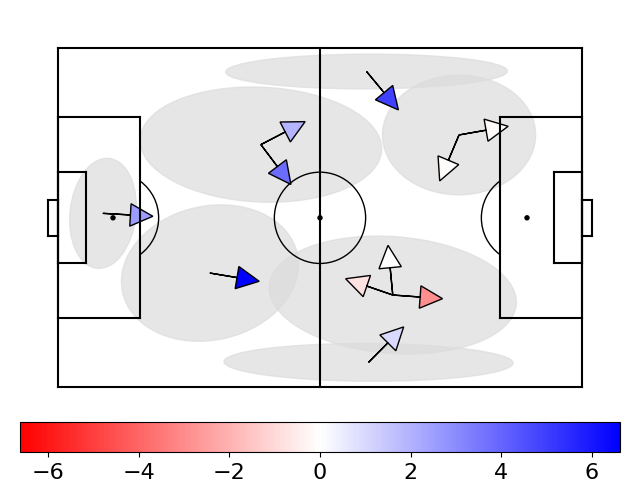

keeper_catch 6
keeper_catch_0 3
keeper_catch_1 2
keeper_catch_2 1
keeper_catch_3 1
keeper_catch_4 2


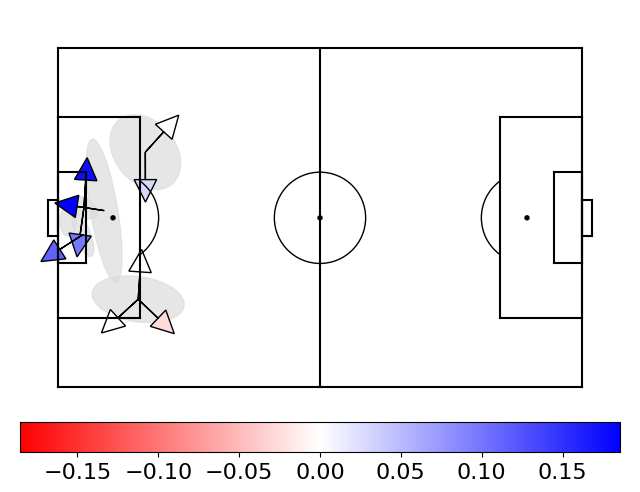

interception 2


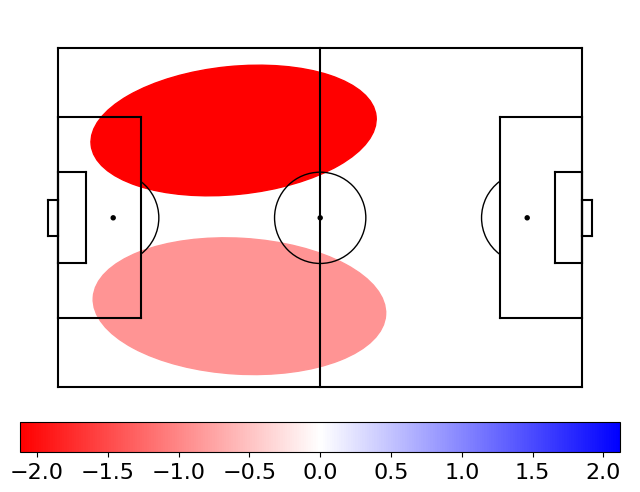

take_on 1


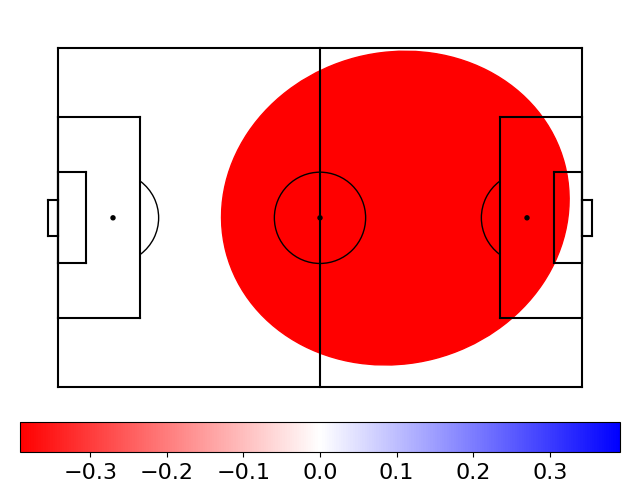

throw_in 2
throw_in_0 1
throw_in_1 2


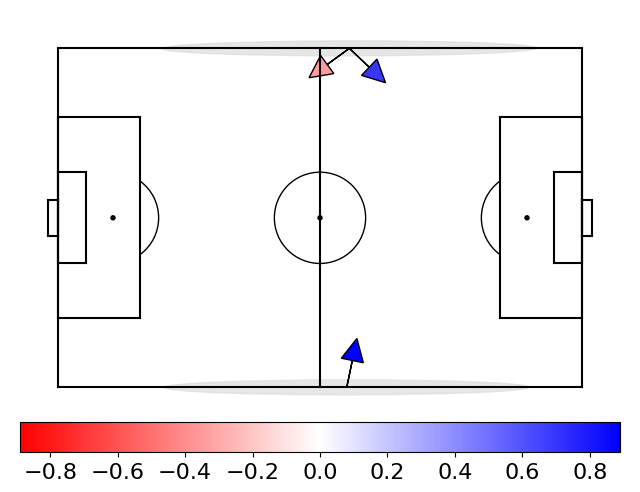

In [68]:
vis.show_component_differences(loc_models, dir_models, mean_pd_machida.loc[0], mean_pd_machida.loc[1], 'Machida Zelvia', 'all', save=False)